In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gc

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_row', 100)
pd.set_option('display.max_info_columns', 100)


    - Datafield
    - DBNOs(Down But Not Out)   적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수
    - assists                   아군이 킬했을 때 같이 데미지를 넣은 수 (말 그대로 어시스트)
    - boosts                    부스트 아이템 사용 횟수
    - damageDealt               총 넣은 데미지 (단, 팀에 준 피해나 자해는 포함되지 않음)
    - headshotKills             헤드샷 킬 수
    - heals                     힐링 아이템 사용 횟수
    - Id                        플레이어 ID
    - killPlace                 매치에서의 킬수만 따졋을때 순위
    - killPoints                킬 수로 산정한 ELO의 개념. rankpoints가 없다면 killPoints가 존재 
    - killStreaks               짧은 시간동안 최대한 많이 킬했을 때의 킬 수 / 죽지않고 킬을 했을때 
    - kills                     총 킬 수
    - longestKill               킬과 킬 사이의 이동한 가장 긴 거리
    - matchDuration             매치의 시간 (초 단위)   -> 맵 사이즈에 따른 시간이 다르다 (평균 : 30분, 23분 )
    - matchId                   매치 ID (트레이닝 데이터와 테스트 데이터에 동일한 매치 ID는 없음)
    - matchType                 매치 타입 “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; 
                                나머지는 이벤트 또는 커스텀 매치


    - rankPoints                랭킹 ELO의 개념
    - revives                   아군 부활 횟수
    - rideDistance              탈것으로 이동한 총 거리
    - roadKills                 탈것으로 킬한 횟수
    - swimDistance              수영한 총 거리
    - teamKills                 팀킬 횟수
    - vehicleDestroys           차량 폭파 횟수
    - walkDistance              걸어간 총 거리 total : 3 map 
                                -> map 2개 : 8 X 8 km => 최대 대각선 길이 : 11.3km
                                   map 1개 : 4 X 4 km => 최대 대각선 길이 : 5.6km
    - weaponsAcquired           얻은 무기의 수
    - winPoints                 승리 횟수로 판단한 ELO의 개념
    - groupId                   매치 내 그룹 아이디, 동일 그룹 구성원들이 다른 게임을 할 때마다 
                                새로운 그룹 아이디가 부여됨
    - numGroups                 게임 내 총 그룹 수 (솔로 -> 듀오 -> 스쿼드로 갈 수록 줄어듦)
    - maxPlace                  한 경기내 최하 등수()
    - winPlacePerc              예측 목표, 1에 가까워질 수록 순위가 높아진다. 
                                (0부터 1까지의 값으로 나타냄. 1은 1등을, 0은 꼴등을 의미한다.)
                                (maxPlace-winPlace)/(maxPlace-1) = winPlacePerc
                                즉, 경기에 들어온 팀수에 따라 경기 등수가 결정된다.

## 사전 지식 전달 사항

- 기본 게임 진행 방식 : 

- 우승 조건 :

- 기타 : 

## 기본 사항

In [2]:
# 이벤트 메치 드랍된 자료 사용
data_path = 'C:/Users/hojun/Documents/dev/Kaggle-PUBG/'
df = pd.read_csv(data_path+'event_drop.csv')

In [3]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [4]:
# df = reduce_mem_usage(df)

## drop

In [5]:
# drop 확인을 위한 DataFrame 생성
drop_proof_df = df.copy()

### drop event game 

In [6]:
# drop_event = ['crashfpp', 'flaretpp', 'flarefpp', 'crashtpp']
# for i in drop_event:
#     indexNames = df[df['matchType'].str.contains(i)].index
#     df.drop(indexNames,  inplace=True)


In [7]:
plt.figure(figsize=(14, 8))
sns.countplot(x='matchType', data=df, order=df.matchType.value_counts().index)
plt.title('Match Type')
plt.xticks(rotation=-45)
plt.show()

#### 이유

전체 데이터의 0.1%도 차지하지 않는 데이터양과 이상치, 특이한 방식의 게임 운영으로 이벤트 경기는 제외

### drop columns

#### 'killPoints', 'winPoints', 'rankPoints' drop

In [8]:
drop_columns = ['killPoints', 'winPoints', 'rankPoints']
df.drop(columns=drop_columns, inplace=True)

##### 이유 

'killPoints', 'winPoints', 'rankPoints' 상관관계도로 확인

결과에 의한 수치들을 계산한 값으로써 너무 높은 영향(leakage)를 확인하여 제외

In [9]:
mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))
plt.figure(figsize=(16, 16))
sns.heatmap(data=df.corr(), mask = mask, vmin = -1, vmax = 1, annot = True, cmap = 'BrBG', cbar = True)
plt.title('PUBG Feature Correlation Heatmap')
plt.show()

C:\Users\hojun\AppData\Local\Temp\ipykernel_18580\4172360554.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


#### 'numGroups' drop

In [10]:
df.drop(columns='numGroups', inplace=True)

##### 이유

- 예측값 : 1 (1등)의 이동 거리 분포 확인

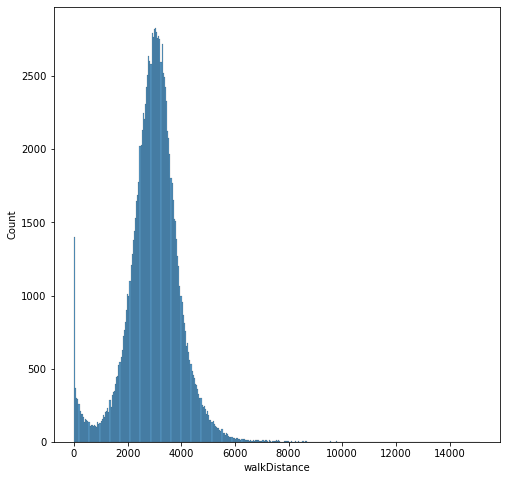

In [11]:
wpp_1 =drop_proof_df[drop_proof_df['winPlacePerc'] == 1]['walkDistance']
plt.figure(figsize=(8, 8))
sns.histplot(data=drop_proof_df, x=wpp_1 )
plt.show()

- 1등인데 이동거리가 0인 data 확인

In [12]:
drop_proof_df[(drop_proof_df['winPlacePerc'] == 1) & (drop_proof_df['walkDistance']==0)]

Id         groupId         matchId  assists  boosts  \
3692     3fc123559fc935  5cef1df7ee3551  01aead02bb8901        0       0   
8770     106afdb574db25  4b0ae4659e9936  cf0cb51c829eb5        0       0   
9243     0351565a7058e9  3663a93a319725  3659fe3694262a        0       0   
18378    e6d6f94558dd2f  22818b9a9a6159  486200c5613f14        0       1   
19006    d0683f5d780f09  faebf5c484de4a  ec9a90395ed8c0        0       0   
...                 ...             ...             ...      ...     ...   
4419845  6cc9d7b1643cbd  11fce60d5c8ea3  60c6e90b964266        3       0   
4420599  69f2d577afb916  1ca82eb3229fe3  8b1af8b54b0edb        0       0   
4422414  87a4d46be07ec6  7921c8beb38c2d  2183f03b8dd456        0       3   
4433367  120b7d2d32663f  b70109a45eb127  6db87452a2db21        0       0   
4436212  2f57d1e882cc06  1c59e2133a2fbd  0027b1ffb2e346        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  killPoints  \
3692          0.0000      0              0      0          1           0   
8770          0.0000      0              0      0          2           0   
9243          0.3218      0              0      0          1           0   
18378         0.0000      0              0      0          2           0   
19006        99.0000      0              0      0          1           0   
...              ...    ...            ...    ...        ...         ...   
4419845     645.6000      6              1      0         28           0   
4420599       0.0000      0              0      0          2           0   
4422414     115.6000      0              0      1          2           0   
4433367       0.0000      0              0      0          2           0   
4436212     116.8000      0              0      0          3           0   

         kills  killStreaks  longestKill  matchDuration         matchType  \
3692         0            0         0.00           1808              solo   
8770         0            0         0.00           1808              solo   
9243         0            0         0.00           1808              solo   
18378        0            0         0.00           1808              solo   
19006        0            0         0.00           1808              solo   
...        ...          ...          ...            ...               ...   
4419845      5            2        57.58           1216  normal-squad-fpp   
4420599      0            0         0.00           1808              solo   
4422414      0            0         0.00           1808              solo   
4433367      0            0         0.00           1808              solo   
4436212      0            0         0.00           1808              solo   

         maxPlace  numGroups  rankPoints  revives  rideDistance  roadKills  \
3692           20          2        1500        0           0.0          0   
8770           18          2        1500        0           0.0          0   
9243           18          2        1500        0           0.0          0   
18378          19          2        1500        0           0.0          0   
19006          17          2        1500        0           0.0          0   
...           ...        ...         ...      ...           ...        ...   
4419845         6          6        1500        2           0.0          0   
4420599        18          2        1500        0           0.0          0   
4422414        20          2        1500        0           0.0          0   
4433367        17          2        1500        0           0.0          0   
4436212        17          2        1500        0           0.0          0   

         swimDistance  teamKills  vehicleDestroys  walkDistance  \
3692              0.0          0                0           0.0   
8770              0.0          0                0           0.0   
9243              0.0          0                0           0.0   
18378             0.0          0                0           0.0  

In [13]:
drop_proof_df[drop_proof_df['matchId']=='01aead02bb8901'][['groupId', 'damageDealt', 'kills', 'killPlace', 'matchType','maxPlace','numGroups','walkDistance','weaponsAcquired','winPlacePerc']]

groupId  damageDealt  kills  killPlace matchType  maxPlace  \
3692     5cef1df7ee3551         0.00      0          1      solo        20   
52397    c70fd467685d53       178.50      0         16      solo        20   
152554   5cef1df7ee3551         0.00      0          4      solo        20   
230675   c70fd467685d53         0.00      0         11      solo        20   
312980   5cef1df7ee3551       119.40      0          3      solo        20   
449983   c70fd467685d53        78.00      0         10      solo        20   
762729   c70fd467685d53         0.00      0         20      solo        20   
1319387  c70fd467685d53         0.00      0         18      solo        20   
1688326  c70fd467685d53       159.00      0          9      solo        20   
1839645  5cef1df7ee3551         0.00      0          2      solo        20   
1888761  c70fd467685d53         0.00      0          7      solo        20   
2307031  c70fd467685d53        95.42      0          5      solo        20   
2318579  c70fd467685d53        99.00      0         17      solo        20   
2524627  c70fd467685d53         0.00      0         19      solo        20   
2705400  c70fd467685d53         0.00      0          6      solo        20   
3019046  c70fd467685d53       287.70      0         13      solo        20   
3173749  c70fd467685d53       335.00      0         12      solo        20   
3329040  c70fd467685d53       104.70      0         15      solo        20   
3399247  c70fd467685d53         0.00      0         14      solo        20   
3615136  c70fd467685d53       288.30      0          8      solo        20   

         numGroups  walkDistance  weaponsAcquired  winPlacePerc  
3692             2           0.0                3           1.0  
52397            2           0.0                3           0.0  
152554           2         592.9                5           1.0  
230675           2           0.0                3           0.0  
312980           2           0.0                8           1.0  
449983           2           0.0                3           0.0  
762729           2           0.0                0           0.0  
1319387          2           0.0                7           0.0  
1688326          2           0.0                5           0.0  
1839645          2           0.0                3           1.0  
1888761          2           0.0                6           0.0  
2307031          2          29.3                2           0.0  
2318579          2           0.0                2           0.0  
2524627          2           0.0                0           0.0  
2705400          2           0.0                2           0.0  
3019046          2           0.0                6           0.0  
3173749          2           0.0                5           0.0  
3329040          2           0.0               18           0.0  
3399247          2           0.0                2           0.0  
3615136          2           0.0                9           0.0

    - 수치상 불가능한 data (이동거리 없이 무기획득 등) 확인  되어 제외

- maxPlace(경기당 마지막 등수)와 numGroups(경기 참가팀수)가 다른 경기들 확인

In [14]:
temp_df = drop_proof_df[drop_proof_df.maxPlace != drop_proof_df.numGroups].sort_values(by=['numGroups','matchId'])[['winPlacePerc', 'numGroups', 'maxPlace', 'matchId']]
temp_df 

winPlacePerc  numGroups  maxPlace         matchId
337842         0.0000          1        18  07baf6b1ba3de9
671026         0.0000          1        18  07baf6b1ba3de9
1056287        0.0000          1        18  07baf6b1ba3de9
1664753        0.0000          1        18  07baf6b1ba3de9
2046163        0.0000          1        18  07baf6b1ba3de9
...               ...        ...       ...             ...
4291031        0.5455         99       100  fe1be8e33af055
4295868        0.1717         99       100  fe1be8e33af055
4334803        0.3737         99       100  fe1be8e33af055
4370186        0.7980         99       100  fe1be8e33af055
4379878        0.0303         99       100  fe1be8e33af055

[3197929 rows x 4 columns]

- numGroups : 1 인 경우 예측값이 0으로 된다.

    -> numGroups : 1 인 경우 제외


In [15]:
temp_df.head(18)

winPlacePerc  numGroups  maxPlace         matchId
337842            0.0          1        18  07baf6b1ba3de9
671026            0.0          1        18  07baf6b1ba3de9
1056287           0.0          1        18  07baf6b1ba3de9
1664753           0.0          1        18  07baf6b1ba3de9
2046163           0.0          1        18  07baf6b1ba3de9
2220777           0.0          1        18  07baf6b1ba3de9
2273755           0.0          1        18  07baf6b1ba3de9
2318787           0.0          1        18  07baf6b1ba3de9
2394697           0.0          1        18  07baf6b1ba3de9
2494260           0.0          1        18  07baf6b1ba3de9
2908661           0.0          1        18  07baf6b1ba3de9
3419441           0.0          1        18  07baf6b1ba3de9
3885884           0.0          1        18  07baf6b1ba3de9
4040957           0.0          1        18  07baf6b1ba3de9
4174364           0.0          1        18  07baf6b1ba3de9
4184210           0.0          1        18  07baf6b1ba3de9
4214601           0.0          1        18  07baf6b1ba3de9
4436437           0.0          1        18  07baf6b1ba3de9

In [16]:
temp_df[temp_df['numGroups']==1]['winPlacePerc'].unique()

array([0.])

numGroups과 maxPlace가 일치하지 않는 경우 확인

- maxPlace : 3 이하인 경우는 없었고

- maxPlace의 value와 winPlacePerc(예측값)의 분할갯수가 일치하였고 

    -> numGroups는 일치하지 않는 경우가 있어서 numGroups는 제외

In [17]:
temp_df[temp_df['maxPlace'] <=3]

Empty DataFrame
Columns: [winPlacePerc, numGroups, maxPlace, matchId]
Index: []

In [18]:
temp_df[temp_df['numGroups']==5]['winPlacePerc'].unique()

array([0.8   , 0.6   , 0.2   , 1.    , 0.    , 0.4   , 0.625 , 0.25  ,
       0.5   , 0.7143, 0.4286, 0.1429, 0.8333, 0.3333])

In [19]:
temp = []
for i in range(4, 101):
    temp.append([i, temp_df[temp_df['maxPlace']==i]['winPlacePerc'].nunique()])
print(temp)

[[4, 4], [5, 5], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], [12, 12], [13, 13], [14, 14], [15, 15], [16, 16], [17, 17], [18, 18], [19, 19], [20, 20], [21, 21], [22, 22], [23, 23], [24, 24], [25, 25], [26, 26], [27, 27], [28, 28], [29, 29], [30, 30], [31, 31], [32, 32], [33, 33], [34, 34], [35, 35], [36, 36], [37, 37], [38, 38], [39, 39], [40, 40], [41, 41], [42, 42], [43, 43], [44, 44], [45, 45], [46, 46], [47, 47], [48, 48], [49, 49], [50, 50], [51, 51], [52, 52], [53, 44], [54, 54], [55, 55], [56, 55], [57, 57], [58, 57], [59, 52], [60, 60], [61, 60], [62, 62], [63, 50], [64, 64], [65, 65], [66, 66], [67, 64], [68, 68], [69, 69], [70, 70], [71, 71], [72, 69], [73, 73], [74, 74], [75, 75], [76, 76], [77, 77], [78, 78], [79, 79], [80, 80], [81, 81], [82, 82], [83, 83], [84, 84], [85, 85], [86, 86], [87, 87], [88, 88], [89, 89], [90, 90], [91, 91], [92, 92], [93, 93], [94, 94], [95, 95], [96, 96], [97, 97], [98, 98], [99, 99], [100, 100]]


In [20]:
# 확인용 DataFrame 삭제
del temp_df
del drop_proof_df
gc.collect()

24253

### drop isna True

- 예측값 결측치가 있는 경기 drop

In [21]:
df[df['winPlacePerc'].isna()]

Id         groupId         matchId  assists  boosts  \
2738537  f70c74418bb064  12dfbede33f92b  224a123c53e008        0       0   

         damageDealt  DBNOs  headshotKills  heals  killPlace  kills  \
2738537          0.0      0              0      0          1      0   

         killStreaks  longestKill  matchDuration matchType  maxPlace  revives  \
2738537            0          0.0              9  solo-fpp         1        0   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
2738537           0.0          0           0.0          0                0   

         walkDistance  weaponsAcquired  winPlacePerc  
2738537           0.0                0           NaN

In [22]:
df.drop(index=df[df['matchId']== '224a123c53e008'].index, inplace=True)

### drop 경기인원 이하 (custom game) - 추가 가능 좀비모드 그래프 추가

#### 이유

- 경기 인원이 일정 이하인 경우 : 이동거리, 무기획득이 너무 높은 수치가 나와서 결과값 예측에 방해가 된다.

In [23]:
df[(df.maxPlace <= 5) & (df.winPlacePerc == 0)][['weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]

weaponsAcquired  walkDistance  winPlacePerc  maxPlace
20333                  3        3033.0           0.0         4
22365                  6         841.4           0.0         4
33176                 12           0.0           0.0         2
41148                 17        2400.0           0.0         3
51253                  2         129.3           0.0         2
...                  ...           ...           ...       ...
4426104               17         614.2           0.0         5
4428841               22         784.4           0.0         3
4431020                8           0.0           0.0         2
4431219               13         186.6           0.0         2
4434642                4        4299.0           0.0         2

[549 rows x 4 columns]

In [24]:
df[df.maxPlace <= 5]['matchType'].value_counts()

normal-squad-fpp    1319
normal-duo-fpp       211
normal-squad         138
squad-fpp             65
normal-duo            20
duo-fpp               15
normal-solo-fpp       10
Name: matchType, dtype: int64

- 대부분이 normal 경기이고 해당 수치와 normal 경기에서 발견되는 각종 이상치들 확인
- 전체 경기 중 차지 비율이 낮으므로 제외

    - normal 경기 제외

In [25]:
df = df.drop(index=df[df['matchType'].str.contains('normal')].index)

In [26]:
df[(df.maxPlace >= 6) &(df.maxPlace <= 10) & (df.winPlacePerc == 0)][['weaponsAcquired', 'walkDistance', 'winPlacePerc', 'maxPlace']]

weaponsAcquired  walkDistance  winPlacePerc  maxPlace
254298                 1       118.600           0.0         7
283360                 3       533.800           0.0         8
378858                 0         0.000           0.0        10
398634                 1        36.290           0.0        10
653482                 2        35.390           0.0         7
680701                 3        57.320           0.0        10
1005322                0         0.000           0.0        10
1061705                1        30.520           0.0        10
1123819                0        29.870           0.0         7
1219599                2        26.890           0.0        10
1380335                3        93.080           0.0        10
1468950                3       139.100           0.0         7
1778814                0         0.000           0.0         9
1798107                2        93.840           0.0        10
1931350                2        89.220           0.0        10
2071976                0         0.000           0.0        10
2125618                2       335.700           0.0         8
2444596                1       134.400           0.0         8
2472389                2        71.500           0.0        10
2664163                4       315.200           0.0         8
2747584                6       940.600           0.0         8
2819274                2       157.500           0.0         8
2853046                2       170.400           0.0         7
3249905                0         0.000           0.0         7
3288588                3        73.910           0.0         6
3325075                1        10.790           0.0        10
3395733                0        48.030           0.0        10
3614247                1         7.684           0.0         9
3652058                2        88.570           0.0         7
3662107                5       394.500           0.0         8
3680544                0         0.000           0.0        10
3729462                0         0.000           0.0        10
3752275                4       931.500           0.0         8
3846011                1        39.890           0.0         8
3858261                1        25.690           0.0        10
3875539                0         0.000           0.0        10
3908669                2       199.700           0.0         8
4035685                0         0.000           0.0        10
4196769                1         3.360           0.0         6
4276741                1        40.440           0.0        10
4303725                0         9.750           0.0        10

## 핵 사용 유저 선별 및 제거 함수 

In [27]:
def hack_user_drop(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    ### Anomalies in aim 1 (More than 50 kills) ###
    df.drop(df[df['kills'] >= 40].index, inplace=True)
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    df.drop(df[df['headshotKills'] >= 15].index, inplace=True)
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    df.drop(df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)].index , inplace=True)
    ### Anomalies in aim 3 (Longest kill) ###
    df.drop(df[df['longestKill'] >= 1000].index, inplace=True)
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    df.drop(df[df['DBNOs'] >= 20].index, inplace=True)
    ### Anomalies in movement ###
    # walkDistance anomalies
    df.drop(df[df['walkDistance'] >= 10000].index, inplace=True)
    # rideDistance anomalies
    df.drop(df[df['rideDistance'] >= 25000].index, inplace=True)
    # swimDistance anomalies
    df.drop(df[df['swimDistance'] >= 1500].index, inplace=True)
    ### Anomalies in item 1 (weaponsAcquired) ###
    df.drop(df[df['weaponsAcquired'] >= 50].index, inplace=True)
    ### Anomalies in item 2 (heals) ###
    df.drop(df[df['heals'] >= 40].index, inplace=True)
    ### Anomalies in item 3 (boosts) ###
    df.drop(df[df['boosts'] >= 15].index, inplace=True)
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    df.drop(df[df['killStreaks'] >= 10].index ,inplace=True)
    # revive zombies (revives >= 10)
    df.drop(df[df['revives'] >= 10].index ,inplace=True)
    #Weapon master (weaponsAcquired >= 50)
    df.drop(df[df['weaponsAcquired'] >= 50].index ,inplace=True)
    #team killer = troll ( teamkills > 4)
    df.drop(df[df['teamKills'] >= 50].index ,inplace=True)
    # Strange road killer (roadKills>= 5)
    df.drop(df[df['roadKills'] >= 5].index, inplace=True)
    # Too little walkDistance
    df.drop(df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)].index, inplace=True)
    df.drop(df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)].index, inplace=True)
    # superman ?
    df.drop(df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)].index, inplace=True)
    # Maybe cheater & Gosu
    df.drop(df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)].index, inplace=True)
    return df

In [28]:

def hack_users(df):
    hack_users = pd.DataFrame()
    ### Anomalies in roadKills ###
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    ### Anomalies in aim 1 (More than 50 kills) ###
    hack_users = pd.concat([hack_users, df[df['kills'] >= 40]])
    ## Anomalies in aim 2 (More than 10 Headshotkills)
    hack_users = pd.concat([hack_users, df[df['headshotKills'] >= 15]])
    ### Anomalies in aim 3 (80% headshot_rate & More than 10 kills) ###
    df['headshot_rate'] = df['headshotKills'] / df['kills']
    df['headshot_rate'] = df['headshot_rate'].fillna(0)
    hack_users = pd.concat([hack_users, df[(df['headshot_rate'] >= 0.8) & (df['kills'] > 10)]])
    ### Anomalies in aim 3 (Longest kill) ###
    hack_users = pd.concat([hack_users, df[df['longestKill'] >= 1000]])
    ### Anomalies in aim 3 (More than 20 DBNo) ###
    hack_users = pd.concat([hack_users, df[df['DBNOs'] >= 20]])
    ### Anomalies in movement ###
    # walkDistance anomalies
    hack_users = pd.concat([hack_users, df[df['walkDistance'] >= 10000]])
    # rideDistance anomalies
    hack_users = pd.concat([hack_users, df[df['rideDistance'] >= 25000]])
    # swimDistance anomalies
    hack_users = pd.concat([hack_users, df[df['swimDistance'] >= 1500]])
    ### Anomalies in item 1 (weaponsAcquired) ###
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    ### Anomalies in item 2 (heals) ###
    hack_users = pd.concat([hack_users, df[df['heals'] >= 40]])
    ### Anomalies in item 3 (boosts) ###
    hack_users = pd.concat([hack_users, df[df['boosts'] >= 15]])
    ## ETC ##
    # drop savage killer (kill streak >= 10)
    hack_users = pd.concat([hack_users, df[df['killStreaks'] >= 10]])
    # revive zombies (revives >= 10)
    hack_users = pd.concat([hack_users, df[df['revives'] >= 10]])
    #Weapon master (weaponsAcquired >= 50)
    hack_users = pd.concat([hack_users, df[df['weaponsAcquired'] >= 50]])
    #team killer.append(troll ( teamkills > 4)
    hack_users = pd.concat([hack_users, df[df['teamKills'] >= 50]])
    # Strange road killer (roadKills>= 5)
    hack_users = pd.concat([hack_users, df[df['roadKills'] >= 5]])
    # Too little walkDistance
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['damageDealt'] >= 1000)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['kills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['heals'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']<=10.0) & (df['headshotKills'] >= 5)]])
    hack_users = pd.concat([hack_users, df[(df['walkDistance']==0) & (df['winPlacePerc'] == 1)]])
    # superman ?
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=1500) & (df['kills'] >= 15) & (df['heals'] == 0)]])
    # Maybe cheater & Gosu
    hack_users = pd.concat([hack_users, df[(df['damageDealt'] >=2500) & (df['kills'] >= 25)]])
    return hack_users

## 핵 유저 관련 feature 생성

In [29]:
# hack_user_drop(df)
# df.drop(columns='headshot_rate', inplace=True)

- 핵사용 유저 확인 (핵 중복 사용 유저 정리 포함)

In [30]:
hack_user = hack_users(df)
df.drop(columns='headshot_rate', inplace=True)
hack_user.drop(columns='headshot_rate', inplace=True)
hack_user = hack_user.drop_duplicates('Id') # 핵 중복 사용 유저 정리

In [234]:
hack_fuature_add_df = df.copy()

- 핵유저 포함 team 표시 feature 생성

In [32]:
hack_user_groupid = str(list(hack_user.groupId.values))

# -> 핵유저가 있는 팀 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_team"] = hack_fuature_add_df.groupId.apply(lambda x : 0 if hack_user_groupid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

- 핵유저 참여 game 표시 feature 생성

In [236]:
hack_user_matchid = str(list(hack_user.matchId.values))

# -> 핵유저가 참여한 경기 : 1   없는 팀 : 0
hack_fuature_add_df["hack_user_game"] = hack_fuature_add_df.matchId.apply(lambda x : 0 if hack_user_matchid.find(x)==-1 else 1) # find 함수는 찾지 못하면 -1 반환

In [34]:
# 핵유저 제거 확인
# set(list(hack_user['groupId'])) & set(list(hack_team_drop[hack_team_drop['hack_user_team']==0]['groupId']))

In [35]:
# 핵 유저가 참여한 경기 수
hack_game_count = round(hack_fuature_add_df.groupby('matchId')['hack_user_game'].agg(np.mean).sum())

print('핵유저수 :', hack_user.index.size, '\t\t\t',  '전체 참가인원 :', df.index.size, '\t','비율 :', round((hack_user.index.size/df.index.size*100), 3))
print('핵유저 포함 팀수 :', len(set(list(hack_user['groupId']))), '\t\t', '전체 참가팀수 :', len(set(list(df['groupId']))), '\t', '비율 :',round( len(set(list(hack_user['groupId'])))/len(set(list(df['groupId'])))*100 ,3))
print('핵유저팀 포함된 인원수 :', hack_fuature_add_df['hack_user_team'].sum(), '\t', '전체 참가인원 :', df.index.size, '\t','비율 :', round((hack_fuature_add_df['hack_user_team'].sum()/df.index.size*100), 3))
print('핵유저팀 포함된 경기수 :',hack_game_count,'\t', '전체 경기수 :', df.matchId.nunique(), '\t\t','비율 :', round((hack_game_count/df.matchId.nunique()*100), 3))

핵유저수 : 1810 			 전체 참가인원 : 4411698 	 비율 : 0.041
핵유저 포함 팀수 : 1343 		 전체 참가팀수 : 2014090 	 비율 : 0.067
핵유저팀 포함된 인원수 : 3419 	 전체 참가인원 : 4411698 	 비율 : 0.077
핵유저팀 포함된 경기수 : 1305 	 전체 경기수 : 47185 		 비율 : 2.766


### 핵유저가 포함된 경기들에서 핵유저가 거둔 성적 정리

In [36]:
# 핵유저가 포함된 팀과 경기
hack_team_include_team = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 1]
hack_team_include_game = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 1]

- 핵유저 포함 팀 또는 개인의 성적 확인 (우승 빈도, 전체 평균 성적)


In [37]:
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
hack_win_count

1005

In [39]:
# 핵유저 개인 or 팀 우승 빈도
hack_win_count = hack_user[hack_user['winPlacePerc']==1].drop_duplicates('Id').index.size
print('핵유저 우승 횟수:', hack_win_count ,'\t\t', '핵유저 참여 경기수:', hack_game_count, '\t', '우승 확률 :', round(hack_win_count/hack_game_count*100, 3))

# 핵유저 개인 or 팀 평균 등수
hack_team_no_include = hack_fuature_add_df[hack_fuature_add_df.hack_user_team == 0]
print('핵유저팀 평균 등수 :', round(hack_team_include_team.winPlacePerc.values.mean(), 3), '\t', '일반 유저팀 평균 등수', round(hack_team_no_include.winPlacePerc.values.mean(), 3))
print('핵유저 평균 등수 :', round(hack_user.winPlacePerc.values.mean(), 3), '\t', '일반 평균 등수 :', round(hack_fuature_add_df.winPlacePerc.values.mean(), 3))


핵유저 우승 횟수: 1005 		 핵유저 참여 경기수: 1305 	 우승 확률 : 77.011
핵유저팀 평균 등수 : 0.771 	 일반 유저팀 평균 등수 0.472
핵유저 평균 등수 : 0.891 	 일반 평균 등수 : 0.473


In [40]:
# 팀별 평균 예상 : 0.5  실제 값 : 0.4998  
# hack_fuature_add_df.groupby('groupId')['winPlacePerc'].agg(np.mean).values.mean()

- 핵유저의 우승 확률이 77% 가 넘는 수치가 나옴
- 핵유저를 포함한 팀은 성적 상승
- 핵유저는 평균 등수 상승 
- 핵유저가 참석한 경기 -> 공정한 경기로 보기 어려움

#### 결과 : 핵유저가 참석한 경기와 같은 팀들의 상황을 분석하고 해당 경기 제외


## 핵유저가 없는 공평한 경기가 이루어졌을때를 전제로 프로젝트를 수행

In [237]:
hack_fuature_add_df = hack_fuature_add_df[hack_fuature_add_df.hack_user_game == 0]

## data 분석을 위해 match type으로 data 분리

### 팀킬, 부활 등 팀원이 존재해야 되는 feature들이 있어서 match type에 따라 분리

- categorical - nominal data => numerical
    - solo : 0, duo : 1, squad : 2

In [42]:
def divide_match_type(x):
    if x.find('solo') != -1:
        return 0
    elif x.find('duo') != -1:
        return 1
    else:
        return 2
hack_fuature_add_df['match_type_numerical'] = hack_fuature_add_df['matchType'].apply(lambda x : divide_match_type(x) )

In [43]:
hack_fuature_add_df[['matchType', 'match_type_numerical']].tail()

matchType  match_type_numerical
4437079  squad-fpp                     2
4437080  squad-fpp                     2
4437081       solo                     0
4437082  squad-fpp                     2
4437084   solo-fpp                     0

In [44]:
# hack_fuature_add_df.to_csv(data_path+'hack_fuature_add_df.csv')
# hack_fuature_add_df = pd.read_csv(data_path+'hack_fuature_add_df.csv')

In [239]:
ppt_df = hack_fuature_add_df.groupby(['matchId', 'groupId']).agg(np.mean)

# Duo, Squad EDA

#### team data에 팀별로 groupby 하여 팀원수 column 추가

In [45]:
hack_fuature_add_df['team_members'] = hack_fuature_add_df.groupby('groupId').Id.transform('count')

- 일부 feature는 합계로 나머지는 평균 feature를 정리

In [46]:
team_df_sum = hack_fuature_add_df[hack_fuature_add_df['hack_user_game']==0].iloc[:, :-5].groupby(['matchId', 'groupId']).agg(sum)
team_df_mean = hack_fuature_add_df[hack_fuature_add_df['hack_user_game']==0][['matchId', 'groupId','winPlacePerc', 'team_members', 'match_type_numerical', 'hack_user_team', 'hack_user_game']].groupby(['matchId', 'groupId']).agg(np.mean)

team_df = pd.concat([team_df_sum, team_df_mean], axis=1, ignore_index=False)

team_df = team_df[team_df['match_type_numerical'] != 0]

In [47]:
team_df

assists  boosts  damageDealt  DBNOs  \
matchId        groupId                                               
0000a43bce5eec 18b16ec699d8b6        0       1       219.35      2   
               236ab9e9c081b9        0       0       287.93      2   
               3a6addfa0df938        0       0         0.00      0   
               4bf06994bd4c9a        0       1        23.40      0   
               4d1bbbc19b9084        2       7       681.90      5   
...                                ...     ...          ...    ...   
fffe92232706aa b671eab579d429        0       0        16.95      0   
               bd5b4ecf8067ab        2       8       617.03      4   
               c8e95cc6c06d41        0       0       155.70      1   
               d57f3a3ed40913        0       2       239.00      3   
               d8fa9cfd6f9560        1       9       730.90      4   

                               headshotKills  heals  killPlace  kills  \
matchId        groupId                                                  
0000a43bce5eec 18b16ec699d8b6              0      1         82      2   
               236ab9e9c081b9              0      0        543      0   
               3a6addfa0df938              0      0        189      0   
               4bf06994bd4c9a              0      0        119      0   
               4d1bbbc19b9084              2      2         28      6   
...                                      ...    ...        ...    ...   
fffe92232706aa b671eab579d429              0      0         29      1   
               bd5b4ecf8067ab              2     20         58      4   
               c8e95cc6c06d41              0      0        492      1   
               d57f3a3ed40913              0      2        243      1   
               d8fa9cfd6f9560              4     13        294      4   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0000a43bce5eec 18b16ec699d8b6            1       12.550           2692   
               236ab9e9c081b9            0        0.000           8076   
               3a6addfa0df938            0        0.000           2692   
               4bf06994bd4c9a            0        0.000           2692   
               4d1bbbc19b9084            3       50.460           2692   
...                                    ...          ...            ...   
fffe92232706aa b671eab579d429            1       32.990           1863   
               bd5b4ecf8067ab            3      348.313           5589   
               c8e95cc6c06d41            1        8.009          11178   
               d57f3a3ed40913            1        2.177           7452   
               d8fa9cfd6f9560            3      153.259          13041   

                               maxPlace  revives  rideDistance  roadKills  \
matchId        groupId                                                      
0000a43bce5eec 18b16ec699d8b6        56        0         0.000          0   
               236ab9e9c081b9       168        0         0.000          0   
               3a6addfa0df938        56        0         0.000          0   
               4bf06994bd4c9a        56        0         0.000          0   
               4d1bbbc19b9084        56        0       159.906          0   
...                                 ...      ...           ...        ...   
fffe92232706aa b671eab579d429        29        0      1732.000          0   
               bd5b4ecf8067ab        87        4     12903.000          1   
               c8e95cc6c06d41       174        0         0.000          0   
               d57f3a3ed40913       116        0         0.000          0   
               d8fa9cfd6f9560       203        2      5919.700          0   

                               swimDistance  teamKills  vehicleDestroys  \
matchId        groupId                                                    
0000a43bce5eec 18b16ec699d8b6         0.000          0 

#### team member를  game type별로 각 수치를 정규화

- duo, squad -> 1명 기준 (수치 / 팀원수)

In [48]:
# duo 경기 정규화
temp_duo = team_df[team_df.match_type_numerical ==1].copy()

for i in range(len(team_df.columns.values)-5):
    temp_duo.iloc[:, i] = (temp_duo.iloc[:, i]/temp_duo.iloc[:, -4])

# squad 경기 정규화
temp_squad = team_df[team_df.match_type_numerical ==2].copy()
for i in range(len(team_df.columns.values)-5):
    temp_squad.iloc[:, i] = (temp_squad.iloc[:, i]/temp_squad.iloc[:, -4])


In [49]:
team_df = pd.concat([temp_duo, temp_squad], axis=0, ignore_index=False)
del temp_duo
del temp_squad
gc.collect()

0

In [50]:
team_df

assists    boosts  damageDealt     DBNOs  \
matchId        groupId                                                     
0003b92987589e 024136db14272c  0.500000  0.000000    11.700000  0.000000   
               058b63035c6c08  0.000000  2.500000   138.500000  1.000000   
               0c7fbc2742917b  0.500000  1.500000   277.800000  1.000000   
               1add3b8ce32302  0.000000  2.000000   223.060000  1.500000   
               1ed2da8e6c07b5  0.000000  1.000000    72.600000  0.000000   
...                                 ...       ...          ...       ...   
fffe92232706aa b671eab579d429  0.000000  0.000000    16.950000  0.000000   
               bd5b4ecf8067ab  0.666667  2.666667   205.676667  1.333333   
               c8e95cc6c06d41  0.000000  0.000000    25.950000  0.166667   
               d57f3a3ed40913  0.000000  0.500000    59.750000  0.750000   
               d8fa9cfd6f9560  0.142857  1.285714   104.414286  0.571429   

                               headshotKills     heals  killPlace     kills  \
matchId        groupId                                                        
0003b92987589e 024136db14272c       0.000000  0.000000  75.500000  0.000000   
               058b63035c6c08       1.000000  3.000000  27.000000  1.500000   
               0c7fbc2742917b       0.500000  2.500000  15.000000  2.500000   
               1add3b8ce32302       0.000000  1.500000  25.500000  2.000000   
               1ed2da8e6c07b5       0.000000  4.000000  46.000000  0.500000   
...                                      ...       ...        ...       ...   
fffe92232706aa b671eab579d429       0.000000  0.000000  29.000000  1.000000   
               bd5b4ecf8067ab       0.666667  6.666667  19.333333  1.333333   
               c8e95cc6c06d41       0.000000  0.000000  82.000000  0.166667   
               d57f3a3ed40913       0.000000  0.500000  60.750000  0.250000   
               d8fa9cfd6f9560       0.571429  1.857143  42.000000  0.571429   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0003b92987589e 024136db14272c     0.000000     0.000000         1410.0   
               058b63035c6c08     1.000000    48.030000         1410.0   
               0c7fbc2742917b     1.500000    43.565000         1410.0   
               1add3b8ce32302     1.000000    72.900000         1410.0   
               1ed2da8e6c07b5     0.500000     2.892500         1410.0   
...                                    ...          ...            ...   
fffe92232706aa b671eab579d429     1.000000    32.990000         1863.0   
               bd5b4ecf8067ab     1.000000   116.104333         1863.0   
               c8e95cc6c06d41     0.166667     1.334833         1863.0   
               d57f3a3ed40913     0.250000     0.544250         1863.0   
               d8fa9cfd6f9560     0.428571    21.894143         1863.0   

                               maxPlace   revives  rideDistance  roadKills  \
matchId        groupId                                                       
0003b92987589e 024136db14272c      50.0  0.000000      0.000000   0.000000   
               058b63035c6c08      50.0  0.000000    501.500000   0.000000   
               0c7fbc2742917b      50.0  0.000000      0.000000   0.000000   
               1add3b8ce32302      50.0  0.000000      0.000000   0.000000   
               1ed2da8e6c07b5      50.0  0.000000    845.450000   0.000000   
...                                 ...       ...           ...        ...   
fffe92232706aa b671eab579d429      29.0  0.000000   1732.000000   0.000000   
               bd5b4ecf8067ab      29.0  1.333333   4301.000000   0.333333   
               c8e95cc6c06d41      29.0  0.000000      0.000000   0.000000   
               d57f3a3ed40913      29.0  0.000000      0.000000   0.000000   
               d8fa9cfd6f9560      29.0  0.285714    845.671429   0.000000   

                               swimDi

- duo, squad 게임에서 상관관계(원본 데이터 heatmap 비교)

In [51]:
mask = np.triu(np.ones_like(team_df.iloc[:, :-3].corr(), dtype=np.bool))

plt.figure(figsize=(16, 16))
sns.heatmap(data=team_df.iloc[:, :-3].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar= True)
plt.title('PUBG Team Feature Correlation Heatmap')
plt.show()

C:\Users\hojun\AppData\Local\Temp\ipykernel_18580\516583274.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(team_df.iloc[:, :-3].corr(), dtype=np.bool))


'killPoints', 'winPoints', 'rankPoints' columns은 상관관계가 너무 높고 

에측값에 대한 독립 column이 아닌 결과로 나온 계산 값이므로 제외

- 팀별로 모았을때 예측값에 대한 상관관계

In [52]:
temp = pd.concat([team_df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp.columns = ['winPlacePerc(after)', 'winPlacePerc(before)']
temp

winPlacePerc(after)  winPlacePerc(before)
winPlacePerc                     1.000000              1.000000
walkDistance                     0.844499              0.814679
boosts                           0.716719              0.636463
weaponsAcquired                  0.706871              0.617926
damageDealt                      0.546226              0.450645
kills                            0.527081              0.431588
longestKill                      0.512686              0.412435
heals                            0.507204              0.430058
killStreaks                      0.485215              0.377973
DBNOs                            0.435345              0.284162
assists                          0.424020              0.305667
revives                          0.373445              0.241897
headshotKills                    0.367316              0.282640
rideDistance                     0.353155              0.345415
swimDistance                     0.166361              0.150905
vehicleDestroys                  0.103791              0.072860
roadKills                        0.039671              0.031816
teamKills                        0.023401              0.016416
matchDuration                    0.004391             -0.004197
match_type_numerical             0.002131                   NaN
maxPlace                        -0.002380              0.038446
team_members                    -0.190388                   NaN
killPlace                       -0.811058             -0.720910
hack_user_team                        NaN                   NaN
hack_user_game                        NaN                   NaN

    - 원본 데이터보다 예측값에 대한 feature들의 상관관계가 더욱 명확해짐

    - walkDistance 아주 높은 상관관계를 확인 할 수 있다
        - 경기에서 오래 살아 남을수록 자기장을 피해 안전 지역으로 이동해야 되므로 
            대체로 이동거리가 늘어난다.(낙하지점과 안전지역이 가까운 경우 제외)

### 데이터 분포에 50%이상이 0 인 feature들의 0인 플레이어들의 winPlacePerc 기준 수치

In [53]:
team_df.describe()

assists        boosts   damageDealt         DBNOs  headshotKills  \
count  1.299387e+06  1.299387e+06  1.299387e+06  1.299387e+06   1.299387e+06   
mean   2.566098e-01  1.211224e+00  1.394426e+02  7.957323e-01   2.356189e-01   
std    4.507457e-01  1.550401e+00  1.367166e+02  8.662529e-01   4.359968e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00   
25%    0.000000e+00  0.000000e+00  4.946500e+01  0.000000e+00   0.000000e+00   
50%    0.000000e+00  5.000000e-01  1.000000e+02  5.000000e-01   0.000000e+00   
75%    5.000000e-01  2.000000e+00  1.892146e+02  1.000000e+00   3.333333e-01   
max    6.666667e+00  1.400000e+01  2.580000e+03  1.800000e+01   1.300000e+01   

              heals     killPlace         kills   killStreaks   longestKill  \
count  1.299387e+06  1.299387e+06  1.299387e+06  1.299387e+06  1.299387e+06   
mean   1.514811e+00  4.564842e+01  9.755212e-01  5.872758e-01  2.450860e+01   
std    2.333649e+00  2.340127e+01  1.223257e+00  5.601226e-01  4.102364e+01   
min    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  2.725000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%    5.000000e-01  4.450000e+01  5.000000e-01  5.000000e-01  7.200000e+00   
75%    2.000000e+00  6.250000e+01  1.500000e+00  1.000000e+00  3.086500e+01   
max    3.900000e+01  1.000000e+02  2.000000e+01  9.000000e+00  9.605500e+02   

       matchDuration      maxPlace       revives  rideDistance     roadKills  \
count   1.299387e+06  1.299387e+06  1.299387e+06  1.299387e+06  1.299387e+06   
mean    1.577280e+03  3.760003e+01  1.914128e-01  6.565111e+02  2.697372e-03   
std     2.537090e+02  9.989491e+00  3.420808e-01  1.477718e+03  4.114083e-02   
min     7.280000e+02  2.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%     1.365000e+03  2.800000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
50%     1.433000e+03  3.100000e+01  0.000000e+00  0.000000e+00  0.000000e+00   
75%     1.847000e+03  4.800000e+01  3.333333e-01  4.195750e+02  0.000000e+00   
max     2.226000e+03  5.100000e+01  9.000000e+00  2.276000e+04  4.000000e+00   

       swimDistance     teamKills  vehicleDestroys  walkDistance  \
count  1.299387e+06  1.299387e+06     1.299387e+06  1.299387e+06   
mean   4.939084e+00  2.633543e-02     8.473561e-03  1.257315e+03   
std    2.805979e+01  1.237418e-01     6.466205e-02  1.159643e+03   
min    0.000000e+00  0.000000e+00     0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00     0.000000e+00  2.199500e+02   
50%    0.000000e+00  0.000000e+00     0.000000e+00  9.234000e+02   
75%    0.000000e+00  0.000000e+00     0.000000e+00  2.105500e+03   
max    1.304000e+03  4.000000e+00     4.000000e+00  9.969000e+03   

       weaponsAcquired  winPlacePerc  team_members  match_type_numerical  \
count     1.299387e+06  1.299387e+06  1.299387e+06          1.299387e+06   
mean      3.792930e+00  5.001981e-01  2.793920e+00          1.517284e+00   
std       1.937892e+00  3.000174e-01  1.485156e+00          4.997014e-01   
min       0.000000e+00  0.000000e+00  1.000000e+00          1.000000e+00   
25%       2.333333e+00  2.391000e-01  2.000000e+00          1.000000e+00   
50%       3.666667e+00  5.000000e-01  2.000000e+00          2.000000e+00   
75%       5.000000e+00  7.660000e-01  3.000000e+00          2.000000e+00   
max       3.400000e+01  1.000000e+00  7.200000e+01          2.000000e+00   

       hack_user_team  hack_user_game  
count       1299387.0       1299387.0  
mean              0.0             0.0  
std               0.0             0.0  
min               0.0             0.0  
25%               0.0             0.0  
50%               0.0             0.0  
75%               0.0             0.0  
max               0.0             0.0

In [54]:
# 함수로 생성
def zeropoint_corr_winPlacePerc(df):
    zero_point_list = ['assists', 'boosts','DBNOs', 'kills','damageDealt', 'headshotKills', 'heals', 'killStreaks', 'longestKill', 'revives', 'roadKills',  'swimDistance','rideDistance',  'teamKills', 'vehicleDestroys']
    
    print('column','\t\t', 'winPlacePerc 평균', '\t', 'count', '\t\t', '전체 대비 비율')
    for i in zero_point_list:
        if len(i) <=6:
            print(i,'\t\t\t', round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100) )
        elif i == 'damageDealt':
            print(i,'\t\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        elif len(i) < 14:
            print(i,'\t\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
        else:
            print(i,'\t',  round(df[df[i] == 0]['winPlacePerc'].values.mean(), 3),'\t\t', df[df[i] == 0]['winPlacePerc'].count(), '\t',(df[df[i] == 0]['winPlacePerc'].count()/df.index.size*100))
    print('참가수 \t\t\t\t\t', df.index.size)

- 팀별 column value : 0 인 데이터들 파악

In [55]:
zeropoint_corr_winPlacePerc(team_df)

column 		 winPlacePerc 평균 	 count 		 전체 대비 비율
assists 		 0.419 		 815436 	 62.755437756418985
boosts 			 0.251 		 483480 	 37.208314382089405
DBNOs 			 0.384 		 329035 	 25.32232506558862
kills 			 0.358 		 409840 	 31.541026653337305
damageDealt 		 0.329 		 99323 		 7.643835131488926
headshotKills 		 0.428 		 828325 	 63.747367027683055
heals 			 0.282 		 493447 	 37.97536838524627
killStreaks 		 0.358 		 409840 	 31.541026653337305
longestKill 		 0.359 		 412540 	 31.748816942142717
revives 		 0.424 		 869124 	 66.8872322102653
roadKills 		 0.499 		 1291637 	 99.40356491176225
swimDistance 		 0.474 		 1156032 	 88.9674900549259
rideDistance 		 0.406 		 855344 	 65.82673214369545
teamKills 		 0.499 		 1222744 	 94.10160329447656
vehicleDestroys 	 0.495 		 1271871 	 97.88238607897416
참가수 					 1299387


- vehicleDestroys, roadKills, teamKills의 경우 최소 94%이 0 인 data이고 예측값 평균도 0.5에 가까운 값 
    
    -> 예측값에 골고루 분포되어있어 영향을 주기가 힘든 것으로 보인다.
- boosts, heals의 경우 아이템을 사용하지 않으면 하위 등수가 나오는것을 확인 할 수 있다.

    -> 두 column은 위의 상관관계에서도 높은 영향이 있었고 수치가 높을수록 높은 등수가 예상된다.

### 차량파괴(vehicleDestroys)와 팀킬(teamkill) 확인 , roadkills 는 제외

In [56]:
team_df = team_df.drop(columns='roadKills')

- 차량파괴(vehicleDestroys)에 따른 등수 확인

In [255]:
 ppt_df[(ppt_df['vehicleDestroys'] >= 0)& (ppt_df['vehicleDestroys'] < 1)]['winPlacePerc'].values.mean()

0.4991235697712966

In [274]:
temp_df = pd.DataFrame(columns=['vehicleDestroys', 'average ranking'])
for i in range(int(ppt_df['vehicleDestroys'].max()) + 1):
    temp_df.loc[i] = [f'{i} ~ {i+1}', ppt_df[(ppt_df['vehicleDestroys'] >= i)& (ppt_df['vehicleDestroys'] < i+1)]['winPlacePerc'].values.mean()]
    # print('차량파괴 수 :', i, '~', i+1, '\t','평균 순위 :' ,team_df[(team_df['vehicleDestroys'] >= i)& (team_df['vehicleDestroys'] < i+1)]['winPlacePerc'].values.mean())
temp_df

vehicleDestroys  average ranking
0           0 ~ 1         0.499124
1           1 ~ 2         0.742355
2           2 ~ 3         0.771389
3           3 ~ 4         0.719190
4           4 ~ 5         0.798300
5           5 ~ 6         0.914900

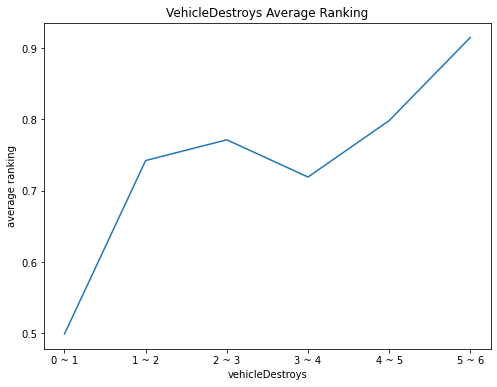

In [275]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='vehicleDestroys', y='average ranking', data=temp_df)
plt.title('VehicleDestroys Average Ranking')
plt.show()

In [249]:
temp_df

Empty DataFrame
Columns: []
Index: []

In [59]:
# g = sns.lineplot(x='vehicleDestroys', y="winPlacePerc", estimator=np.mean, data=team_df[team_df["vehicleDestroys"] <=5])

In [60]:
team_df = team_df.drop(columns='vehicleDestroys')

    - 값들의 분포가 일정하지 않고 예측값에 영향이 적으므로 제외

- 팀킬에 따른 등수 확인

In [276]:
temp_df = pd.DataFrame(columns=['teamKills', 'average ranking'])
for i in range(int(ppt_df['teamKills'].max()) + 1):
    temp_df.loc[i] = [f'{i} ~ {i+1}', ppt_df[(ppt_df['teamKills'] >= i)& (ppt_df['teamKills'] < i+1)]['winPlacePerc'].values.mean()]
    # print('팀킬수 :', i, '~', i+1, '\t', '평균 승률:', team_df[(team_df['teamKills'] >= i)& (team_df['teamKills'] < i+1)]['winPlacePerc'].values.mean())
temp_df

teamKills  average ranking
0     0 ~ 1         0.499362
1     1 ~ 2         0.536485
2     2 ~ 3         0.513003
3     3 ~ 4         0.521205
4     4 ~ 5         0.445100

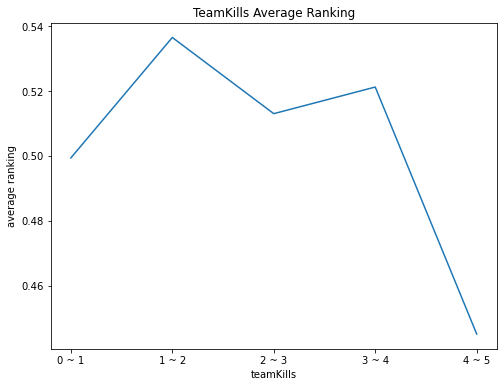

In [278]:
plt.figure(figsize=(8, 6))
sns.lineplot(x='teamKills', y='average ranking', data=temp_df)
plt.title('TeamKills Average Ranking')
plt.show()

In [62]:
# g = sns.lineplot(x='teamKills', y="winPlacePerc", estimator=np.mean, data=team_df[team_df["teamKills"] <=5])

In [63]:
for i in range(1, 5):
    print('팀킬수 :', i,'~', i+1, '\t', '평균 팀원수 :', round(team_df[(team_df['teamKills'] >= i)& (team_df['teamKills'] < i+1)]['team_members'].mean(),3),'\t', '팀수:',team_df[(team_df['teamKills'] >= i)& (team_df['teamKills'] < i+1)].index.size)

팀킬수 : 1 ~ 2 	 평균 팀원수 : 1.582 	 팀수: 8225
팀킬수 : 2 ~ 3 	 평균 팀원수 : 1.027 	 팀수: 300
팀킬수 : 3 ~ 4 	 평균 팀원수 : 1.0 	 팀수: 43
팀킬수 : 4 ~ 5 	 평균 팀원수 : 1.0 	 팀수: 5


In [64]:
team_df = team_df.drop(columns='teamKills')

    - 데이터 양이 많은 1킬에 경우 예측값이 너무 불분명하고 나머지 값들은 너무 작은 값이어서 제외

### 맵크기 구분

- 4(km) X 4(km) , 8(km) X 8(km) 사이즈 2개 
- 게임 전문가 : 평균 게임시간 작은 맵 - 23분, 큰 맵 - 30분 

In [65]:
plt.figure(figsize=(12,8))
sns.histplot(data=team_df , x='matchDuration')
plt.show()

In [66]:
# 4(km) X 4(km) : 0 , 8(km) X 8(km) : 1

team_df['maptype'] = team_df['matchDuration'].apply(lambda x : 0 if x<1600 else 1)

- matchDuration 사용 완료 제외

In [67]:
team_df = team_df.drop(columns='matchDuration')

In [68]:
team_df.corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']

winPlacePerc            1.000000
walkDistance            0.844499
boosts                  0.716719
weaponsAcquired         0.706871
damageDealt             0.546226
kills                   0.527081
longestKill             0.512686
heals                   0.507204
killStreaks             0.485215
DBNOs                   0.435345
assists                 0.424020
revives                 0.373445
headshotKills           0.367316
rideDistance            0.353155
swimDistance            0.166361
maptype                 0.004263
match_type_numerical    0.002131
maxPlace               -0.002380
team_members           -0.190388
killPlace              -0.811058
hack_user_team               NaN
hack_user_game               NaN
Name: winPlacePerc, dtype: float64

### 거리 관련 feature(walkDistance, rideDistance, swimDistance) 확인

- ppt 용

#### swimdistance 확인

- 수영을 한 플레이어

- 전체 선수 수영한 선수

In [221]:
ppt_df[ppt_df['swimDistance']>0]['winPlacePerc'].mean()

0.7302523784038362

- 전체 선수 수영 안한

In [222]:
ppt_df[ppt_df['swimDistance']==0]['winPlacePerc'].mean()

0.47543721578529785

In [305]:
sns.jointplot(y='swimDistance', x ='winPlacePerc', data=ppt_df, height=10, ratio=3)
plt.show()

In [281]:
zeropoint_corr_winPlacePerc(ppt_df)


column 		 winPlacePerc 평균 	 count 		 전체 대비 비율
assists 		 0.45 		 1443913 	 73.46703375260572
boosts 			 0.291 		 879689 	 44.759027347766775
DBNOs 			 0.461 		 995037 	 50.627992728157125
kills 			 0.365 		 768233 	 39.08808892285446
damageDealt 		 0.339 		 306533 		 15.59655620337755
headshotKills 		 0.436 		 1371648 	 69.7901535014188
heals 			 0.331 		 937034 	 47.67677034927946
killStreaks 		 0.365 		 768233 	 39.08808892285446
longestKill 		 0.366 		 773327 	 39.347274254613204
revives 		 0.457 		 1535126 	 78.10799795867382
roadKills 		 0.499 		 1954569 	 99.44947285244804
swimDistance 		 0.475 		 1778541 	 90.493077960648
rideDistance 		 0.418 		 1386370 	 70.53921640957591
teamKills 		 0.499 		 1880976 	 95.70502328037858
vehicleDestroys 	 0.496 		 1934935 	 98.4504848658459
참가수 					 1965389


In [69]:
team_df[team_df['swimDistance']>0]['winPlacePerc'].mean()

0.7152851445711693

- 수영을 하진 않은 플레이어

In [70]:
team_df[team_df['swimDistance']==0]['winPlacePerc'].mean()


0.47352594270746834

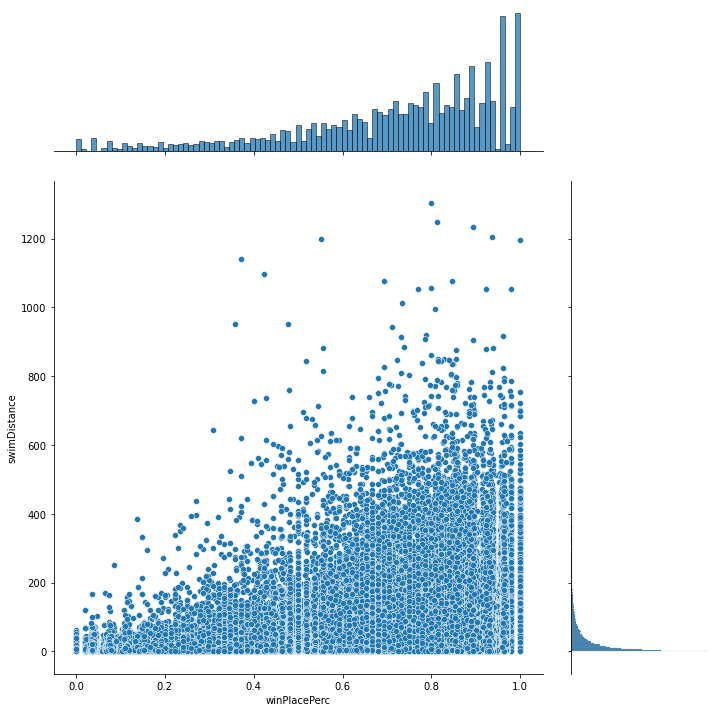

In [71]:
sns.jointplot(y='swimDistance', x ='winPlacePerc', data=team_df[team_df['swimDistance']>0], height=10, ratio=3)
plt.show()

- 맵 사이즈별 예측값 상관관계

In [72]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['swimDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['swimDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
swimDistance  0.208592  0.135464

In [73]:
team_df = team_df.drop(columns='swimDistance')

- 큰 맵은 수영하게에는 강 간격이 너무 넓어서 수영을 하기가 힘든 것으로 보인다

    - 75% 이상이 0인 수치 제외

#### rideDistance 확인

In [ ]:
ppt_df['maptype'] = ppt_df['matchDuration'].apply(lambda x : 0 if x<1600 else 1)

In [286]:
temp_df = pd.DataFrame(columns=['condition', 'average ranking'])

temp_df.loc[0] = ['small map no riding', ppt_df[(ppt_df.maptype == 0) & (ppt_df['rideDistance']==0)]['winPlacePerc'].mean()]
temp_df.loc[1] = ['small map riding', ppt_df[(ppt_df.maptype == 0) & (ppt_df['rideDistance']>0)]['winPlacePerc'].mean()]

temp_df.loc[2] = ['large map no riding', ppt_df[(ppt_df.maptype == 1) & (ppt_df['rideDistance']==0)]['winPlacePerc'].mean()]
temp_df.loc[3] = ['large map riding', ppt_df[(ppt_df.maptype == 1) & (ppt_df['rideDistance']>0)]['winPlacePerc'].mean()]
temp_df

condition  average ranking
0  small map no riding         0.455180
1     small map riding         0.724375
2  large map no riding         0.331355
3     large map riding         0.679685

In [293]:
plt.figure(figsize=(8, 6))
sns.barplot(x='condition', y='average ranking', data=temp_df)
sns.lineplot(x='condition', y=0.5, data=temp_df)
plt.title('Riding Average Ranking')
plt.show()

- 차량 이용한 플레이어

In [74]:

print('작은 맵 차량 이용안한 : ', team_df[(team_df.maptype == 0) & (team_df['rideDistance']==0)]['winPlacePerc'].mean())
print('작은 맵 차량 이용 : ', team_df[(team_df.maptype == 0) & (team_df['rideDistance']>0)]['winPlacePerc'].mean())

print('큰 맵 차량 이용안한 : ', team_df[(team_df.maptype == 1) & (team_df['rideDistance']==0)]['winPlacePerc'].mean())
print('큰 맵 차량 이용 : ', team_df[(team_df.maptype == 1) & (team_df['rideDistance']>0)]['winPlacePerc'].mean())


작은 맵 차량 이용안한 :  0.4464017710464243
작은 맵 차량 이용 :  0.7132472086249037
큰 맵 차량 이용안한 :  0.30687259637229225
큰 맵 차량 이용 :  0.6661220031353068


- 맵 사이즈별 예측값 상관관계

In [75]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['rideDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['rideDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc    1.0000  1.000000
rideDistance    0.2635  0.543594

In [303]:
plt.figure(figsize=(12, 8))
sns.histplot(x='rideDistance', data=ppt_df[ppt_df.rideDistance < 1000], bins=50)
plt.title('Riding Distance less than 1000(m) Count')
plt.show()

In [296]:
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=ppt_df, height=10, ratio=3)
plt.show()

- 작은 맵

In [76]:
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=team_df[team_df.maptype==0], height=10, ratio=3)
plt.show()

- 큰 맵 

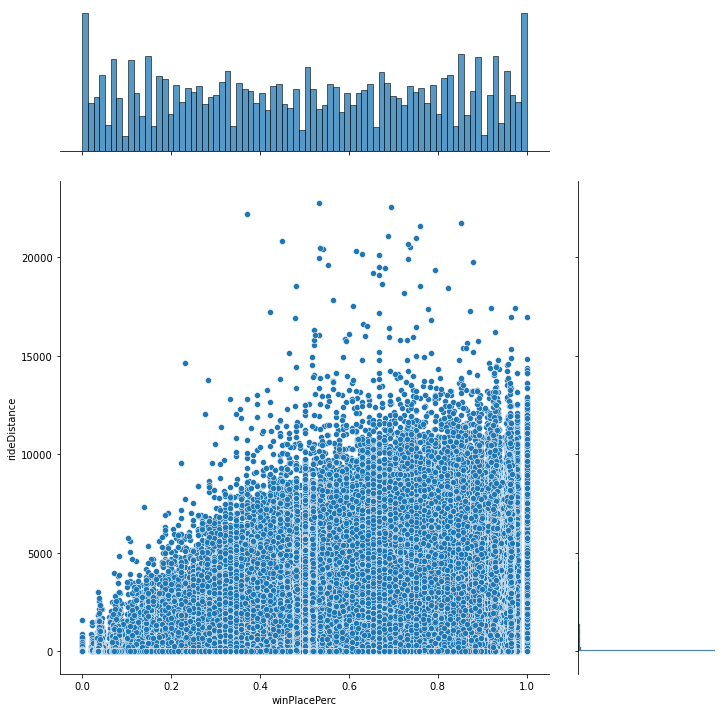

In [77]:
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=team_df[team_df.maptype==1], height=10, ratio=3)
plt.show()

    - 멥 사이즈에 따라 차량 이동 거리가 등수에 다른 영향을 주는 것을 확인 할 수 있다.

#### walkdistance 확인

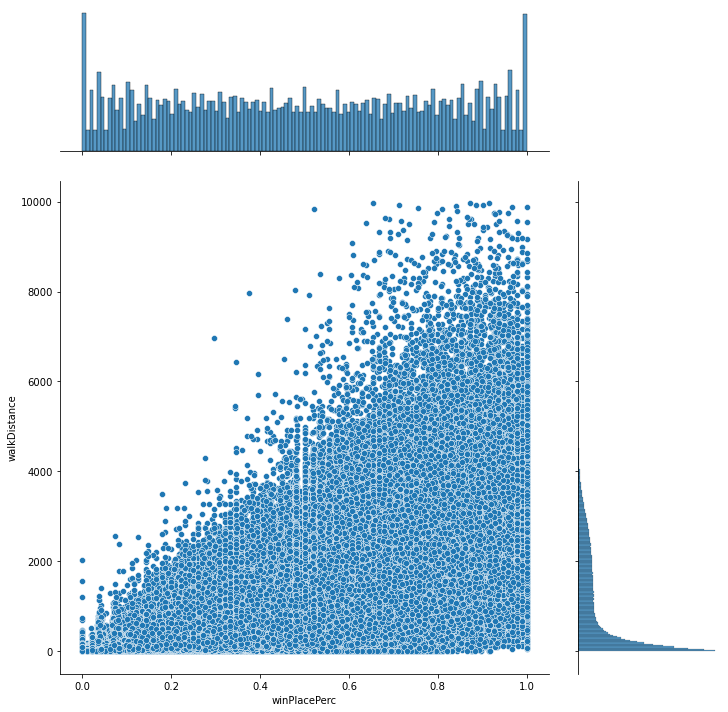

In [306]:
sns.jointplot(y='walkDistance', x ='winPlacePerc', data=ppt_df, height=10, ratio=3)
plt.show()

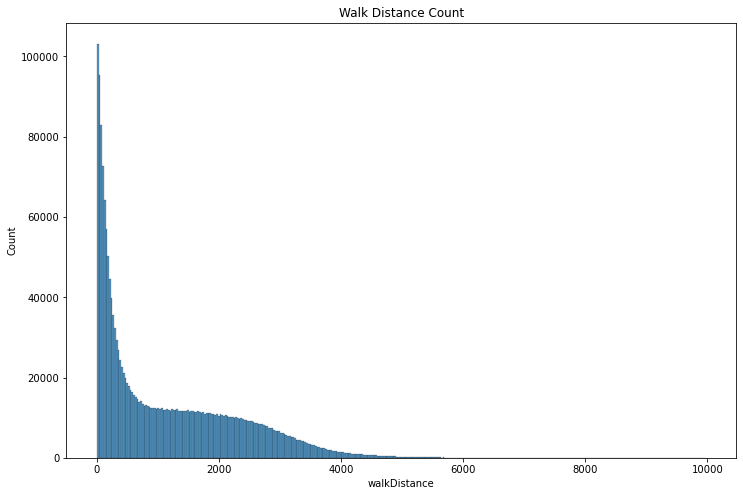

In [307]:
plt.figure(figsize=(12, 8))
sns.histplot(x='walkDistance', data=ppt_df)
plt.title('Walk Distance Count')
plt.show()

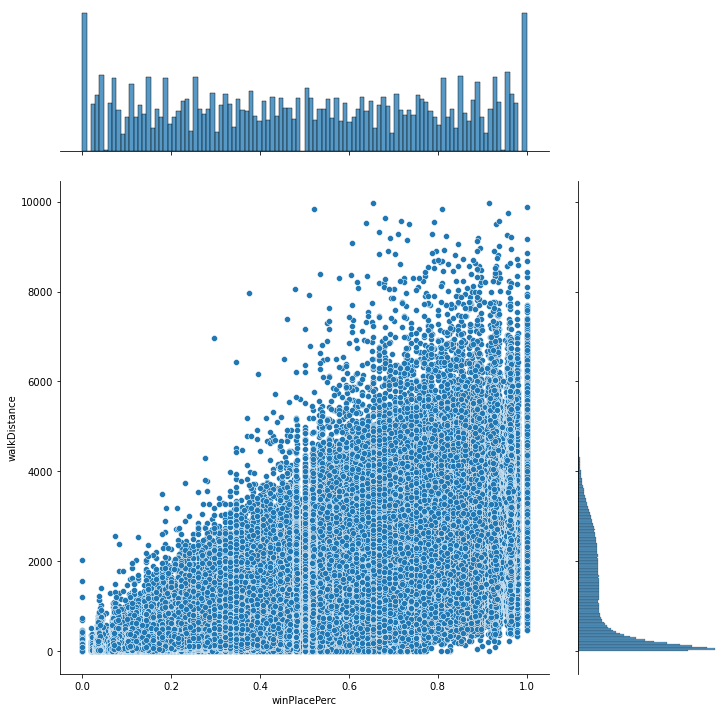

In [78]:
sns.jointplot(y='walkDistance', x ='winPlacePerc', data=team_df, height=10, ratio=3)
plt.show()

- 맵 사이즈별 예측값 상관관계

In [79]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['walkDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['walkDistance', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
walkDistance  0.880691  0.836806

    - 작은 맵에서 조금 더 상관관계가 높음

### 아이템 관련 feature(boosts, heals, weaponsAcquired) 확인

In [80]:
team_df[['boosts', 'heals', 'weaponsAcquired']].describe()

boosts         heals  weaponsAcquired
count  1.299387e+06  1.299387e+06     1.299387e+06
mean   1.211224e+00  1.514811e+00     3.792930e+00
std    1.550401e+00  2.333649e+00     1.937892e+00
min    0.000000e+00  0.000000e+00     0.000000e+00
25%    0.000000e+00  0.000000e+00     2.333333e+00
50%    5.000000e-01  5.000000e-01     3.666667e+00
75%    2.000000e+00  2.000000e+00     5.000000e+00
max    1.400000e+01  3.900000e+01     3.400000e+01

C:\Users\hojun\AppData\Local\Temp\ipykernel_18580\2330804704.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(ppt_df[['boosts', 'heals', 'weaponsAcquired', 'winPlacePerc']].corr(), dtype=np.bool))


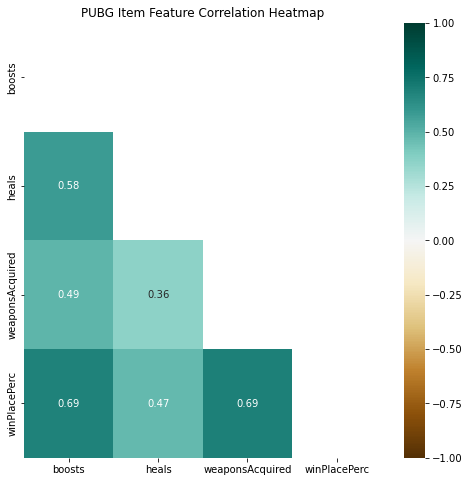

In [312]:
mask = np.triu(np.ones_like(ppt_df[['boosts', 'heals', 'weaponsAcquired', 'winPlacePerc']].corr(), dtype=np.bool))

plt.figure(figsize=(8, 8))
sns.heatmap(data=ppt_df[['boosts', 'heals', 'weaponsAcquired', 'winPlacePerc']].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG', cbar= True)
plt.title('PUBG Item Feature Correlation Heatmap')
plt.show()

In [308]:
ppt_df[['boosts', 'heals', 'weaponsAcquired', 'winPlacePerc']].corr()


boosts     heals  weaponsAcquired  winPlacePerc
boosts           1.000000  0.579211         0.491401      0.686819
heals            0.579211  1.000000         0.359407      0.471152
weaponsAcquired  0.491401  0.359407         1.000000      0.688473
winPlacePerc     0.686819  0.471152         0.688473      1.000000

In [81]:
team_df[['boosts', 'heals', 'weaponsAcquired', 'winPlacePerc']].corr()


boosts     heals  weaponsAcquired  winPlacePerc
boosts           1.000000  0.625576         0.535184      0.716719
heals            0.625576  1.000000         0.405440      0.507204
weaponsAcquired  0.535184  0.405440         1.000000      0.706871
winPlacePerc     0.716719  0.507204         0.706871      1.000000

#### boosts 확인

In [313]:
sns.jointplot(y='boosts', x ='winPlacePerc', hue='maptype' , data=ppt_df, height=10, ratio=3)
plt.show()

- boosts 사용한 플레이어

In [82]:
team_df[team_df['boosts']>0]['winPlacePerc'].mean()

0.6476126366117702

- boosts 사용 안한 플레이어

In [83]:
team_df[team_df['boosts']==0]['winPlacePerc'].mean()

0.2514254178042526

- 맵 사이즈별 예측값 상관관계

In [84]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['boosts', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['boosts', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
boosts        0.715375  0.726488

- boost 아이템 사용에 대한 등수 확인

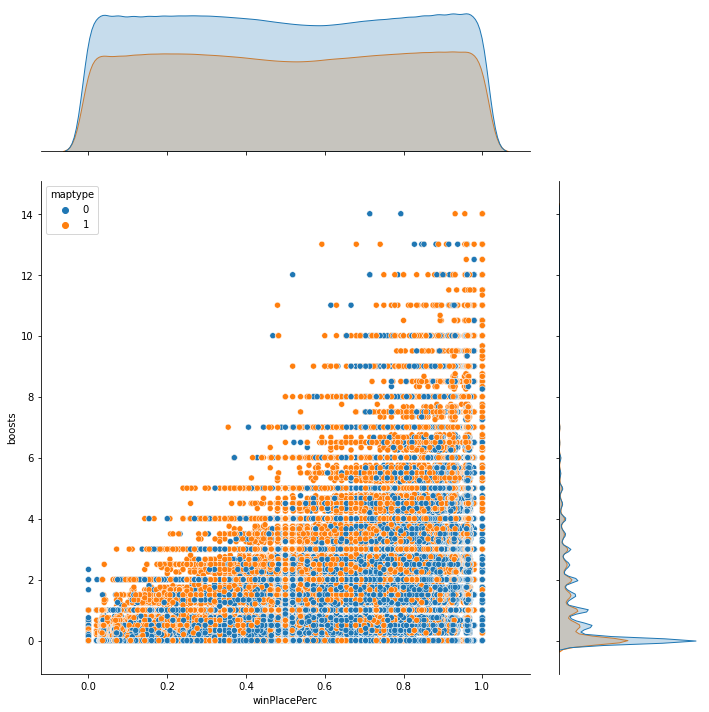

In [85]:
sns.jointplot(y='boosts', x ='winPlacePerc', hue='maptype' , data=team_df, height=10, ratio=3)
plt.show()

- 사용 유무에 따라 많은 등수 차이 예상
- 등수와 높은 상관관계를 확인


#### heals 확인

- heals 사용한 플레이어

In [86]:
team_df[team_df['heals']>0]['winPlacePerc'].mean()

0.6340806293272452

- heals 사용 안한 플레이어

In [87]:
team_df[team_df['heals']==0]['winPlacePerc'].mean()

0.2815295302231039

- 맵 사이즈별 예측값 상관관계

In [88]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['heals', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['heals', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
heals         0.516642  0.523401

- heal 아이템 사용에 대한 등수 확인

In [89]:
sns.jointplot(y='heals', x ='winPlacePerc', hue='maptype', data=team_df, height=10, ratio=3)
plt.show()

- 사용 유무에 따라 많은 등수 차이 예상
- 등수와 높은 상관관계를 확인


#### 무기획득(weaponsAcquired) 확인

- 무기획득(weaponsAcquired)한 플레이어

In [90]:
team_df[team_df['weaponsAcquired']>0]['winPlacePerc'].mean()

0.5028069620571755

- 무기획득(weaponsAcquired) 못한 플레이어

In [91]:
team_df[team_df['weaponsAcquired']==0]['winPlacePerc'].mean()

0.08439354480375216

- 맵 사이즈별 예측값 상관관계

In [92]:
temp_df =  pd.concat([team_df[team_df.maptype==0][['weaponsAcquired', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc'], team_df[team_df.maptype==1][['weaponsAcquired', 'winPlacePerc']].corr().nlargest(team_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc      1.00000  1.000000
weaponsAcquired   0.72992  0.720303

- 무기획득(weaponsAcquired)에 대한 등수 확인

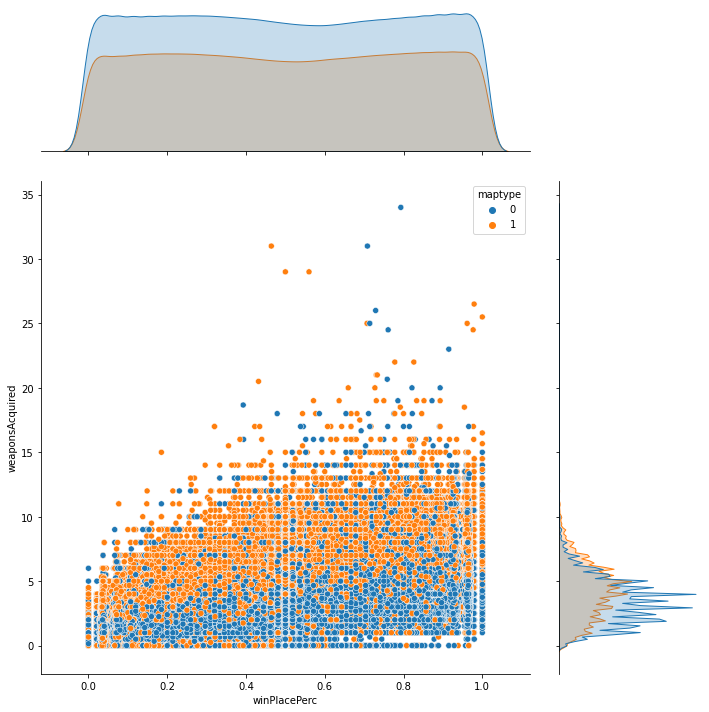

In [93]:
sns.jointplot(y='weaponsAcquired', x ='winPlacePerc', hue='maptype', data=team_df, height=10, ratio=3)
plt.show()

- 획득하지 못한 경우 최하위권 예상
- 등수와 높은 상관관계를 확인


#### 아이템들간의 상관 관계 확인

- heals, boosts 관계 확인

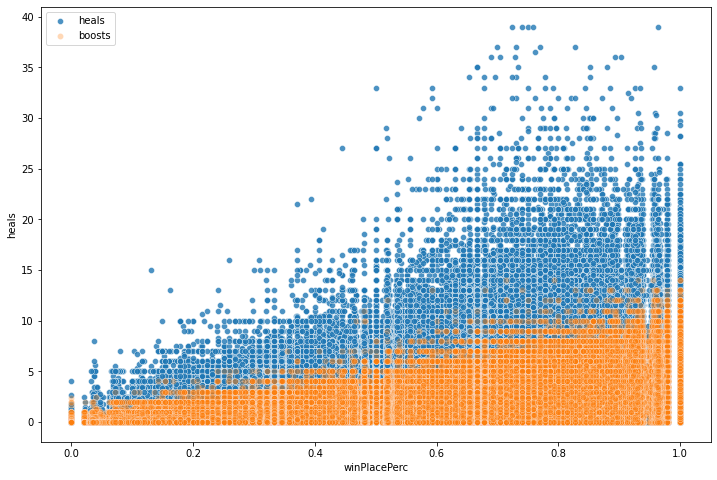

In [94]:
plt.figure(figsize=(12, 8))
g0 = sns.scatterplot(x='winPlacePerc', y='heals', data=team_df, alpha=0.8, label='heals')
g1 = sns.scatterplot(x='winPlacePerc', y='boosts', data=team_df, alpha=0.3, label='boosts')
# g2 = sns.scatterplot(x='weaponsAcquired', y='boosts', data=team_df, alpha=0.3, label='weaponsAcquired')


    - heals와 boost는 관계성이 있어 보임

- heals와 boosts를 합친 feature 생성 후 등수와의 관계 확인

In [95]:
team_df['items'] = team_df.heals + team_df.boosts

In [96]:
team_df[['boosts', 'heals', 'items', 'winPlacePerc']].corr()

boosts     heals     items  winPlacePerc
boosts        1.000000  0.625576  0.855674      0.716719
heals         0.625576  1.000000  0.939035      0.507204
items         0.855674  0.939035  1.000000      0.652310
winPlacePerc  0.716719  0.507204  0.652310      1.000000

- heals, boosts, weaponsAcquired 각각의 관계 확인

In [97]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
g2 = sns.scatterplot(x='heals', y='boosts', data=team_df, alpha=0.5, hue='maptype')
plt.subplot(2, 2, 2)
g2 = sns.scatterplot(x='weaponsAcquired', y='boosts', data=team_df, alpha=0.5, hue='maptype')
plt.subplot(2, 2, 3)
g2 = sns.scatterplot(x='weaponsAcquired', y='heals', data=team_df, alpha=0.5, hue='maptype')
plt.show()


    - feature들을 개별로 사용 

### Kill 관련 feature(kills, longestkill, killstreaks, headshotkills) 확인

In [98]:
team_df[['kills', 'longestKill', 'killStreaks', 'headshotKills']].describe()

kills   longestKill   killStreaks  headshotKills
count  1.299387e+06  1.299387e+06  1.299387e+06   1.299387e+06
mean   9.755212e-01  2.450860e+01  5.872758e-01   2.356189e-01
std    1.223257e+00  4.102364e+01  5.601226e-01   4.359968e-01
min    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
25%    0.000000e+00  0.000000e+00  0.000000e+00   0.000000e+00
50%    5.000000e-01  7.200000e+00  5.000000e-01   0.000000e+00
75%    1.500000e+00  3.086500e+01  1.000000e+00   3.333333e-01
max    2.000000e+01  9.605500e+02  9.000000e+00   1.300000e+01

In [99]:
team_df[['kills', 'longestKill', 'killStreaks', 'headshotKills', 'winPlacePerc']].corr()

kills  longestKill  killStreaks  headshotKills  winPlacePerc
kills          1.000000     0.658189     0.846092       0.710361      0.527081
longestKill    0.658189     1.000000     0.571284       0.505266      0.512686
killStreaks    0.846092     0.571284     1.000000       0.581500      0.485215
headshotKills  0.710361     0.505266     0.581500       1.000000      0.367316
winPlacePerc   0.527081     0.512686     0.485215       0.367316      1.000000

In [100]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
g2 = sns.scatterplot(x='winPlacePerc', y='kills', data=team_df, alpha=0.5)
plt.subplot(2, 2, 2)
g2 = sns.scatterplot(x='winPlacePerc', y='longestKill', data=team_df, alpha=0.5)
plt.subplot(2, 2, 3)
g2 = sns.scatterplot(x='winPlacePerc', y='killStreaks', data=team_df, alpha=0.5)
plt.subplot(2, 2, 4)
g2 = sns.scatterplot(x='winPlacePerc', y='headshotKills', data=team_df, alpha=0.5)
plt.show()

In [101]:
team_df = team_df.drop(columns=['killStreaks', 'headshotKills'])

- headshotKills data 에 0이 50% 이상 포함 
    
    -> 다수의 수량을 차지하는 2 이하의 분포가 평균에 가까운 분포를 유지하고 있어서 제외
- killStreaks feature는 시간 기준이 모호하고 예측값 분포가 평균에 가까운 분포 -> 제외

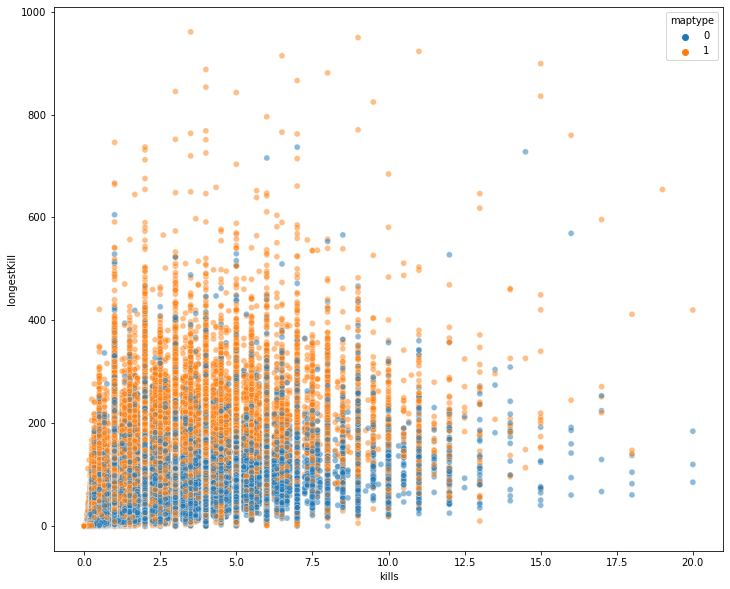

In [102]:
plt.figure(figsize=(12, 10))
g2 = sns.scatterplot(x='kills', y='longestKill', data=team_df, alpha=0.5, hue='maptype')

### 나머지 feature(damageDealt, DBNOs, assists, revives) 확인

In [103]:
team_df[['damageDealt', 'DBNOs', 'assists', 'revives']].describe()

damageDealt         DBNOs       assists       revives
count  1.299387e+06  1.299387e+06  1.299387e+06  1.299387e+06
mean   1.394426e+02  7.957323e-01  2.566098e-01  1.914128e-01
std    1.367166e+02  8.662529e-01  4.507457e-01  3.420808e-01
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00
25%    4.946500e+01  0.000000e+00  0.000000e+00  0.000000e+00
50%    1.000000e+02  5.000000e-01  0.000000e+00  0.000000e+00
75%    1.892146e+02  1.000000e+00  5.000000e-01  3.333333e-01
max    2.580000e+03  1.800000e+01  6.666667e+00  9.000000e+00

In [104]:
team_df[['damageDealt', 'DBNOs', 'assists', 'revives', 'winPlacePerc']].corr()

damageDealt     DBNOs   assists   revives  winPlacePerc
damageDealt      1.000000  0.877346  0.582450  0.402741      0.546226
DBNOs            0.877346  1.000000  0.517545  0.390663      0.435345
assists          0.582450  0.517545  1.000000  0.357067      0.424020
revives          0.402741  0.390663  0.357067  1.000000      0.373445
winPlacePerc     0.546226  0.435345  0.424020  0.373445      1.000000

In [105]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
g2 = sns.scatterplot(x='winPlacePerc', y='damageDealt', data=team_df, alpha=0.5)
plt.subplot(2, 2, 2)
g2 = sns.scatterplot(x='winPlacePerc', y='DBNOs', data=team_df, alpha=0.5)
plt.subplot(2, 2, 3)
g2 = sns.scatterplot(x='winPlacePerc', y='assists', data=team_df, alpha=0.5)
plt.subplot(2, 2, 4)
g2 = sns.scatterplot(x='winPlacePerc', y='revives', data=team_df, alpha=0.5)
plt.show()

In [106]:
team_df = team_df.drop(columns=['assists', 'revives'])

- assists, revives data 에 0이 50% 이상 포함 
    
    -> 다수의 수량을 차지하는 2 이하의 분포가 평균에 가까운 분포를 유지하고 있어서 제외

    - damageDealt는 그대로 사용

#### 킬과 기절 관계 확인

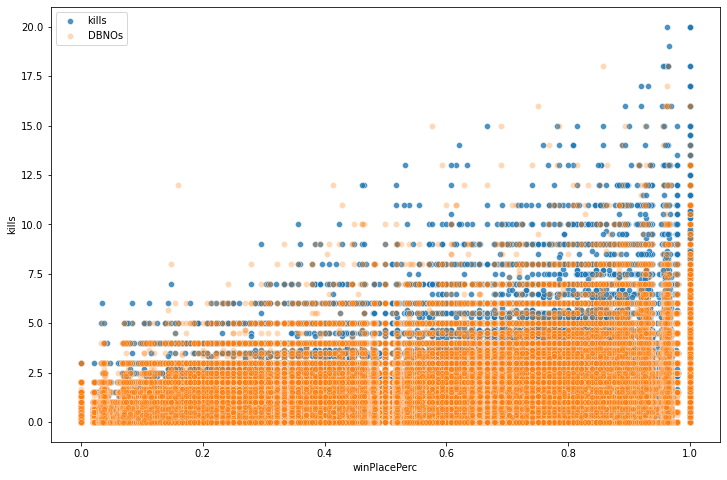

In [107]:
plt.figure(figsize=(12, 8))
g0 = sns.scatterplot(x='winPlacePerc', y='kills', data=team_df, alpha=0.8, label='kills')
g1 = sns.scatterplot(x='winPlacePerc', y='DBNOs', data=team_df, alpha=0.3, label='DBNOs')

In [108]:
team_df['kill_dbno'] = team_df.kills + team_df.DBNOs

In [109]:
team_df[['kills', 'DBNOs', 'kill_dbno', 'winPlacePerc']].corr()

kills     DBNOs  kill_dbno  winPlacePerc
kills         1.000000  0.848902   0.973748      0.527081
DBNOs         0.848902  1.000000   0.946930      0.435345
kill_dbno     0.973748  0.946930   1.000000      0.508035
winPlacePerc  0.527081  0.435345   0.508035      1.000000

In [110]:
team_df[['kills', 'DBNOs']].corr()

kills     DBNOs
kills  1.000000  0.848902
DBNOs  0.848902  1.000000

In [111]:
team_df = team_df.drop(columns='DBNOs')

    - 두의 상관관계가 너무 높고 합계의 방법도 kills의 예측값과의 관계보다 좋지 않음 -> DBNOs 제외 

## 생성한 feature 정리

In [112]:
team_df = team_df.drop(columns=['hack_user_team', 'hack_user_game', 'items', 'kill_dbno'])

In [113]:
team_df

boosts  damageDealt     heals  killPlace  \
matchId        groupId                                                      
0003b92987589e 024136db14272c  0.000000    11.700000  0.000000  75.500000   
               058b63035c6c08  2.500000   138.500000  3.000000  27.000000   
               0c7fbc2742917b  1.500000   277.800000  2.500000  15.000000   
               1add3b8ce32302  2.000000   223.060000  1.500000  25.500000   
               1ed2da8e6c07b5  1.000000    72.600000  4.000000  46.000000   
...                                 ...          ...       ...        ...   
fffe92232706aa b671eab579d429  0.000000    16.950000  0.000000  29.000000   
               bd5b4ecf8067ab  2.666667   205.676667  6.666667  19.333333   
               c8e95cc6c06d41  0.000000    25.950000  0.000000  82.000000   
               d57f3a3ed40913  0.500000    59.750000  0.500000  60.750000   
               d8fa9cfd6f9560  1.285714   104.414286  1.857143  42.000000   

                                  kills  longestKill  maxPlace  rideDistance  \
matchId        groupId                                                         
0003b92987589e 024136db14272c  0.000000     0.000000      50.0      0.000000   
               058b63035c6c08  1.500000    48.030000      50.0    501.500000   
               0c7fbc2742917b  2.500000    43.565000      50.0      0.000000   
               1add3b8ce32302  2.000000    72.900000      50.0      0.000000   
               1ed2da8e6c07b5  0.500000     2.892500      50.0    845.450000   
...                                 ...          ...       ...           ...   
fffe92232706aa b671eab579d429  1.000000    32.990000      29.0   1732.000000   
               bd5b4ecf8067ab  1.333333   116.104333      29.0   4301.000000   
               c8e95cc6c06d41  0.166667     1.334833      29.0      0.000000   
               d57f3a3ed40913  0.250000     0.544250      29.0      0.000000   
               d8fa9cfd6f9560  0.571429    21.894143      29.0    845.671429   

                               walkDistance  weaponsAcquired  winPlacePerc  \
matchId        groupId                                                       
0003b92987589e 024136db14272c    281.850000         2.500000        0.1837   
               058b63035c6c08   2712.000000         5.500000        0.9796   
               0c7fbc2742917b   2033.500000         5.500000        0.7755   
               1add3b8ce32302   1176.110000         2.000000        0.8980   
               1ed2da8e6c07b5    628.800000         3.000000        0.5306   
...                                     ...              ...           ...   
fffe92232706aa b671eab579d429   2988.000000         3.000000        0.6429   
               bd5b4ecf8067ab   2023.000000         7.666667        0.9286   
               c8e95cc6c06d41     91.383333         0.666667        0.0000   
               d57f3a3ed40913    292.180000         2.750000        0.2500   
               d8fa9cfd6f9560   1380.671429         4.714286        0.4643   

                               team_members  match_type_numerical  maptype  
matchId        groupId                                                      
0003b92987589e 024136db14272c           2.0                   1.0        0  
               058b63035c6c08           2.0                   1.0        0  
               0c7fbc2742917b           2.0                   1.0        0  
               1add3b8ce32302           2.0                   1.0        0  
               1ed2da8e6c07b5           2.0                   1.0        0  
...                                     ...                   ...      ...  
fffe92232706aa b671eab579d429           1.0                   2.0        1  
               bd5b4ecf8067ab           3.0                   2.0        1  
               c8e95cc6c06d41           6.0                   2.0        1  
               d57f3a3ed40913           4.0                   2.0        1  
               d8fa9cfd6f9560           7.0        

In [114]:
solo_df = hack_fuature_add_df[hack_fuature_add_df.match_type_numerical == 0].copy()

## solo game 확인 

In [115]:
solo_df = hack_fuature_add_df[hack_fuature_add_df.match_type_numerical == 0].copy()

### solo game groupid 중복 확인

In [116]:
solo_df['team_members'].value_counts()

1     650284
2      27268
3       4299
4       1456
5        545
16       368
18       342
17       289
6        186
19       171
15       165
14       126
8        120
13       104
7         84
10        70
11        66
64        64
12        48
9         45
20        20
Name: team_members, dtype: int64

- 5명 이상이 동일 등수 경기수

In [117]:
solo_df[(solo_df.match_type_numerical == 0)& (solo_df.team_members>=5)]['matchId'].nunique()

286

- solo 전체 경기수

In [118]:
solo_df[solo_df.match_type_numerical == 0].matchId.nunique()

7337

- 경기 비중도 적고 solo 경기에 5명이상이 같은 등수를 가지는 것은 일반적이지 않다고 판단

In [119]:
solo_df = solo_df.drop(index=solo_df[solo_df.team_members>=5].index).copy()

    - solo 동일 등수 인원 5명 이상인 경기 제외

### team member수가 많아서 각 수치를 정규화


In [120]:
solo_df

Id         groupId         matchId  assists  boosts  \
4        315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   
13       b7807186e3f679  3c08e461874749  2c30ddf481c52d        0       1   
17       92022479b92ce7  2f2c33f548c4b9  07948d723b9c0f        0       3   
35       47143f942503e0  e17a8867a393ec  bc2faecb77e5ec        0       0   
36       269c3fc4a26935  3c07be51998e6f  ce9bc89b3ca08c        0       1   
...                 ...             ...             ...      ...     ...   
4437069  d05b0c4b2ff311  8248fa2552457b  88c002b589d411        0       0   
4437073  894c01c8e4524f  c33e793af077f9  deb3a91c03d0f3        0       0   
4437078  d29bfa313ad766  ac3f1b4a56e5ad  2f3b1af94739b3        0       0   
4437081  f4197cf374e6c0  408cdb5c46b2ac  ee854b837376d9        0       1   
4437084  0d8e7ed728b6fd  8c74f72fedf5ff  62a16aabcc095c        0       2   

         damageDealt  DBNOs  headshotKills  heals  killPlace  kills  \
4             100.00      0              0      0         45      1   
13            324.20      0              1      5          5      4   
17            254.30      0              0     12         13      2   
35            136.90      0              0      0         37      1   
36            100.00      0              0      0         24      1   
...              ...    ...            ...    ...        ...    ...   
4437069       203.50      0              0      0         32      1   
4437073        30.10      0              0      0         58      0   
4437078        22.68      0              0      0         89      0   
4437081        44.15      0              0      0         69      0   
4437084       268.00      0              0      1         18      2   

         killStreaks  longestKill  matchDuration matchType  maxPlace  revives  \
4                  1        58.53           1424  solo-fpp        97        0   
13                 1        49.83           1886  solo-fpp        97        0   
17                 1        36.00           1371  solo-fpp        96        0   
35                 1        22.83           1425  solo-fpp        96        0   
36                 1        21.25           1398      solo        92        0   
...              ...          ...            ...       ...       ...      ...   
4437069            1        11.27           1897  solo-fpp        95        0   
4437073            0         0.00           1908  solo-fpp        99        0   
4437078            0         0.00           1456  solo-fpp        96        0   
4437081            0         0.00           1435      solo        93        0   
4437084            1        78.25           1766  solo-fpp        98        0   

         rideDistance  roadKills  swimDistance  teamKills  vehicleDestroys  \
4                 0.0          0          0.00          0                0   
13             1228.0          0         76.84          0                0   
17             2367.0          0         15.29          0                0   
35                0.0          0          0.00          0                0   
36                0.0          0         61.00          0                0   
...               ...        ...           ...        ...              ...   
4437069           0.0          0          0.00          0                0   
4437073           0.0          0          0.00          0                0   
4437078           0.0          0          0.00          0                0   
4437081           0.0          0          0.00          0                0   
4437084        1369.0          0          0.00          0                0   

         walkDistance  weaponsAcquired  winPlacePerc  hack_user_team  \
4               49.75                2        0.1875               0   
13            2050.00                6        0.8750               0   
17            1787.00                3        0.8211               0   
35             270.70                1        0.3474     

In [121]:
### match ID 별로 그룹화
solo_df_sum = solo_df[solo_df['hack_user_game']==0].iloc[:, :-5].groupby(['matchId', 'groupId']).agg(sum)
solo_df_mean = solo_df[solo_df['hack_user_game']==0][['matchId', 'groupId','winPlacePerc', 'team_members', 'match_type_numerical', 'hack_user_team', 'hack_user_game']].groupby(['matchId', 'groupId']).agg(np.mean)

solo_df = pd.concat([solo_df_sum, solo_df_mean], axis=1, ignore_index=False)


In [122]:
for i in range(len(solo_df.columns.values)-5):
    solo_df.iloc[:, i] = (solo_df.iloc[:, i]/solo_df.iloc[:, -4])

In [123]:
solo_df

assists  boosts  damageDealt  DBNOs  \
matchId        groupId                                               
0002912fe5ed71 02567acfab9ba3      0.0     2.0       150.80    0.0   
               058f14af19432b      1.0     5.0       211.20    0.0   
               0acd4dd6620a6c      0.0     1.0         0.00    0.0   
               0b4163b79274bc      0.0     1.0       216.40    0.0   
               0db3c3ce6cc6b0      0.0     5.0       128.80    0.0   
...                                ...     ...          ...    ...   
fffe53015be300 ebc64887a0aa6d      0.0     0.0       193.70    0.0   
               f60269d17d29d8      0.0     0.0        47.43    0.0   
               f7890153b51671      0.0     0.0        63.00    0.0   
               f8e2e7c28d3227      0.0     4.0         0.00    0.0   
               fbbc9d8dc219d1      0.0     0.0        25.80    0.0   

                               headshotKills  heals  killPlace  kills  \
matchId        groupId                                                  
0002912fe5ed71 02567acfab9ba3            1.0    0.0       27.0    1.0   
               058f14af19432b            0.0   29.0       26.0    1.0   
               0acd4dd6620a6c            0.0    4.0       59.0    0.0   
               0b4163b79274bc            0.0    0.0       11.0    3.0   
               0db3c3ce6cc6b0            0.0    7.0       14.0    2.0   
...                                      ...    ...        ...    ...   
fffe53015be300 ebc64887a0aa6d            0.0    0.0       41.0    1.0   
               f60269d17d29d8            0.0    0.0       71.0    0.0   
               f7890153b51671            0.0    0.0       81.0    0.0   
               f8e2e7c28d3227            0.0    9.0       46.0    0.0   
               fbbc9d8dc219d1            0.0    0.0       58.0    0.0   

                               killStreaks  longestKill  matchDuration  \
matchId        groupId                                                   
0002912fe5ed71 02567acfab9ba3          1.0      191.800         1949.0   
               058f14af19432b          1.0        2.102         1949.0   
               0acd4dd6620a6c          0.0        0.000         1949.0   
               0b4163b79274bc          1.0       55.000         1949.0   
               0db3c3ce6cc6b0          1.0      206.500         1949.0   
...                                    ...          ...            ...   
fffe53015be300 ebc64887a0aa6d          1.0       20.850         1882.0   
               f60269d17d29d8          0.0        0.000         1882.0   
               f7890153b51671          0.0        0.000         1882.0   
               f8e2e7c28d3227          0.0        0.000         1882.0   
               fbbc9d8dc219d1          0.0        0.000         1882.0   

                               maxPlace  revives  rideDistance  roadKills  \
matchId        groupId                                                      
0002912fe5ed71 02567acfab9ba3      95.0      0.0     3581.0000        0.0   
               058f14af19432b      95.0      0.0        0.0000        0.0   
               0acd4dd6620a6c      95.0      0.0     2168.0000        0.0   
               0b4163b79274bc      95.0      0.0     2005.0000        1.0   
               0db3c3ce6cc6b0      95.0      0.0        0.0000        0.0   
...                                 ...      ...           ...        ...   
fffe53015be300 ebc64887a0aa6d      97.0      0.0        0.0000        0.0   
               f60269d17d29d8      97.0      0.0        0.0000        0.0   
               f7890153b51671      97.0      0.0        0.0000        0.0   
               f8e2e7c28d3227      97.0      0.0        0.1962        0.0   
               fbbc9d8dc219d1      97.0      0.0        0.0000        0.0   

                               swimDistance  teamKills  vehicleDestroys  \
matchId        groupId                                                    
0002912fe5ed71 02567acfab9ba3          0.00        0.0 

In [124]:
zeropoint_corr_winPlacePerc(solo_df)

column 		 winPlacePerc 평균 	 count 		 전체 대비 비율
assists 		 0.49 		 628196 	 94.36410475954425
boosts 			 0.339 		 395959 	 59.478755924081625
DBNOs 			 0.499 		 665715 	 100.0
kills 			 0.373 		 358110 	 53.79328992136274
damageDealt 		 0.344 		 207065 		 31.10415117580346
headshotKills 		 0.45 		 543039 	 81.57229445032785
heals 			 0.385 		 443347 	 66.59711738506718
killStreaks 		 0.373 		 358110 	 53.79328992136274
longestKill 		 0.374 		 360503 	 54.15275305498599
revives 		 0.499 		 665715 	 100.0
roadKills 		 0.498 		 662646 	 99.53899191095289
swimDistance 		 0.479 		 622229 	 93.46777524916818
rideDistance 		 0.439 		 530765 	 79.72856252300159
teamKills 		 0.498 		 657946 	 98.83298408478103
vehicleDestroys 	 0.498 		 662778 	 99.55882021585813
참가수 					 665715


In [125]:
### 솔로 경기에 해당하지않는 DBNOs, revives, teamKills 제외 
solo_df = solo_df.drop(columns='DBNOs')
solo_df = solo_df.drop(columns='revives')
solo_df = solo_df.drop(columns='teamKills')

- vehicleDestroys, roadKills 경우 최소 94%이 0 인 data이고 예측값 평균도 0.5에 가까운 값 
    
    -> 예측값에 골고루 분포되어있어 영향을 주기가 힘든 것으로 보인다. 

In [126]:
### roadKills 제외
solo_df = solo_df.drop(columns='roadKills')

### 차량파괴(vehicleDestroys) 확인 

- 차량파괴(vehicleDestroys)에 따른 등수 확인

In [127]:
solo_df['vehicleDestroys'].nunique()

9

In [128]:
for i in range(int(solo_df['vehicleDestroys'].max()) + 1):
    print('차량파괴 수 :', i, '~', i+1, '\t','평균 순위 :' ,solo_df[(solo_df['vehicleDestroys'] >= i)& (solo_df['vehicleDestroys'] < i+1)]['winPlacePerc'].values.mean())

차량파괴 수 : 0 ~ 1 	 평균 순위 : 0.4976565984647788
차량파괴 수 : 1 ~ 2 	 평균 순위 : 0.766972919655667
차량파괴 수 : 2 ~ 3 	 평균 순위 : 0.8274012345679014
차량파괴 수 : 3 ~ 4 	 평균 순위 : 0.7913749999999999
차량파괴 수 : 4 ~ 5 	 평균 순위 : 0.9043
차량파괴 수 : 5 ~ 6 	 평균 순위 : 0.9149


In [129]:
solo_df = solo_df.drop(columns='vehicleDestroys')

    - 값들의 분포가 일정하지 않고 예측값에 영향이 적으므로 제외

### 맵크기 구분

- 4(km) X 4(km) , 8(km) X 8(km) 사이즈 2개 

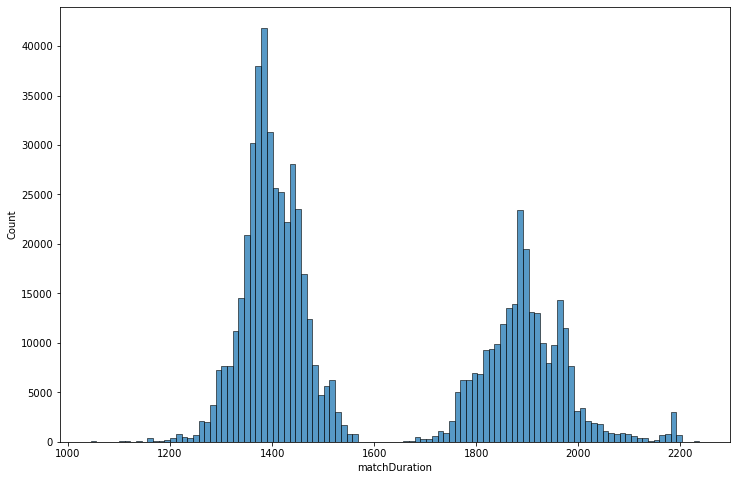

In [130]:
plt.figure(figsize=(12,8))
sns.histplot(data=solo_df , x='matchDuration')
plt.show()

In [131]:
# 4(km) X 4(km) : 0 , 8(km) X 8(km) : 1

solo_df['maptype'] = solo_df['matchDuration'].apply(lambda x : 0 if x<1600 else 1)

- matchDuration 사용 완료 제외

In [132]:
solo_df = solo_df.drop(columns='matchDuration')

In [133]:
solo_df.corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc']

winPlacePerc            1.000000
walkDistance            0.819788
weaponsAcquired         0.668855
boosts                  0.643586
damageDealt             0.510049
kills                   0.501256
killStreaks             0.444097
longestKill             0.441262
heals                   0.406691
headshotKills           0.349243
rideDistance            0.318620
swimDistance            0.168114
assists                 0.134665
maptype                 0.002504
maxPlace               -0.003256
team_members           -0.126967
killPlace              -0.791716
match_type_numerical         NaN
hack_user_team               NaN
hack_user_game               NaN
Name: winPlacePerc, dtype: float64

### 거리 관련 feature(walkDistance, rideDistance, swimDistance) 확인

#### swimdistance 확인

- 수영을 한 플레이어

In [134]:
solo_df[solo_df['swimDistance']>0]['winPlacePerc'].mean()

0.7797105850158672

- 수영을 하진 않은 플레이어

In [135]:
solo_df[solo_df['swimDistance']==0]['winPlacePerc'].mean()


0.4791993057218485

In [136]:
plt.figure(figsize=(12, 8))
sns.jointplot(y='swimDistance', x ='winPlacePerc', data=solo_df[solo_df['swimDistance']>0], height=10, ratio=3)
plt.show()

<Figure size 864x576 with 0 Axes>

In [137]:
temp_df =  pd.concat([solo_df[solo_df.maptype==0][['swimDistance', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc'], solo_df[solo_df.maptype==1][['swimDistance', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
swimDistance  0.201902  0.141415

- 큰 맵은 수영하게에는 강 간격이 너무 넓어서 수영을 하기가 힘든 것으로 보인다

    - 75% 이상이 0인 수치이나 승률이 높은 구간에 가중치를 더 줄 수 있는 수치로 보여 삭제
    

In [138]:
solo_df = solo_df.drop(columns='swimDistance')

#### rideDistance 확인

- 차량 이용한 플레이어

In [139]:

print('작은 맵 차량 이용안한 : ', solo_df[(solo_df.maptype == 0) & (solo_df['rideDistance']==0)]['winPlacePerc'].mean())
print('작은 맵 차량 이용 : ', solo_df[(solo_df.maptype == 0) & (solo_df['rideDistance']>0)]['winPlacePerc'].mean())

print('큰 맵 차량 이용안한 : ', solo_df[(solo_df.maptype == 1) & (solo_df['rideDistance']==0)]['winPlacePerc'].mean())
print('큰 맵 차량 이용 : ', solo_df[(solo_df.maptype == 1) & (solo_df['rideDistance']>0)]['winPlacePerc'].mean())


작은 맵 차량 이용안한 :  0.46982811861218615
작은 맵 차량 이용 :  0.767295133062233
큰 맵 차량 이용안한 :  0.3689813613954088
큰 맵 차량 이용 :  0.72139329524642


In [140]:
temp_df =  pd.concat([solo_df[solo_df.maptype==0][['rideDistance', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc'], solo_df[solo_df.maptype==1][['rideDistance', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
rideDistance  0.232398  0.484208

- 작은 맵

In [141]:
plt.figure(figsize=(12, 8))
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=solo_df[solo_df.maptype==0], height=10, ratio=3)
plt.show()

<Figure size 864x576 with 0 Axes>

- 큰 맵 

In [142]:
plt.figure(figsize=(12, 8))
sns.jointplot(y='rideDistance', x ='winPlacePerc', data=solo_df[solo_df.maptype==1], height=10, ratio=3)
plt.show()

<Figure size 864x576 with 0 Axes>

    - 멥 사이즈에 따라 차량 이동 거리가 등수에 다른 영향을 주는 것을 확인 할 수 있다.

#### walkdistance 확인

In [143]:
plt.figure(figsize=(12, 8))
sns.jointplot(y='walkDistance', x ='winPlacePerc', data=solo_df, height=10, ratio=3)
plt.show()

<Figure size 864x576 with 0 Axes>

In [144]:
temp_df =  pd.concat([solo_df[solo_df.maptype==0][['walkDistance', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc'], solo_df[solo_df.maptype==1][['walkDistance', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc   1.00000  1.000000
walkDistance   0.85372  0.824839

    - 작은 맵에서 조금 더 상관관계가 높음

### 아이템 관련 feature(boosts, heals, weaponsAcquired) 확인

In [145]:
solo_df[['boosts', 'heals', 'weaponsAcquired']].describe()

boosts          heals  weaponsAcquired
count  665715.000000  665715.000000    665715.000000
mean        1.090836       1.030269         3.587808
std         1.812287       2.378293         2.331238
min         0.000000       0.000000         0.000000
25%         0.000000       0.000000         2.000000
50%         0.000000       0.000000         3.000000
75%         2.000000       1.000000         5.000000
max        14.000000      39.000000        32.000000

#### boosts 확인

- boosts 사용한 플레이어

In [146]:
solo_df[solo_df['boosts']>0]['winPlacePerc'].mean()

0.7329601517667818

- boosts 사용 안한 플레이어

In [147]:
solo_df[solo_df['boosts']==0]['winPlacePerc'].mean()

0.33932250712826334

In [148]:
plt.figure(figsize=(12, 8))
sns.jointplot(y='boosts', x ='winPlacePerc', data=solo_df, height=10, ratio=3)
plt.show()

<Figure size 864x576 with 0 Axes>

#### heals 확인

- heals 사용한 플레이어

In [149]:
solo_df[solo_df['heals']>0]['winPlacePerc'].mean()

0.7253222828824291

- heals 사용 안한 플레이어

In [150]:
solo_df[solo_df['heals']==0]['winPlacePerc'].mean()

0.38522812582469274

- 맵 사이즈별 예측값 상관관계

In [151]:
temp_df =  pd.concat([solo_df[solo_df.maptype==0][['heals', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc'], solo_df[solo_df.maptype==1][['heals', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc  1.000000  1.000000
heals         0.405612  0.421931

- heal 아이템 사용에 대한 등수 확인

In [152]:
sns.jointplot(y='heals', x ='winPlacePerc', hue='maptype', data=solo_df, height=10, ratio=3)
plt.show()

- 사용 유무에 따라 많은 등수 차이 예상
- 등수와 높은 상관관계를 확인


#### 무기획득(weaponsAcquired) 확인

- 무기획득(weaponsAcquired)한 플레이어

In [153]:
solo_df[solo_df['weaponsAcquired']>0]['winPlacePerc'].mean()

0.5193435863274447

- 무기획득(weaponsAcquired) 못한 플레이어

In [154]:
solo_df[solo_df['weaponsAcquired']==0]['winPlacePerc'].mean()

0.10516785855093562

- 맵 사이즈별 예측값 상관관계

In [155]:
temp_df =  pd.concat([solo_df[solo_df.maptype==0][['weaponsAcquired', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc'], solo_df[solo_df.maptype==1][['weaponsAcquired', 'winPlacePerc']].corr().nlargest(solo_df.columns.size, 'winPlacePerc')['winPlacePerc']], axis=1)
temp_df.columns = [['small_map', 'large_map']]
temp_df

small_map large_map
winPlacePerc     1.000000  1.000000
weaponsAcquired  0.683275  0.678986

- 무기획득(weaponsAcquired)에 대한 등수 확인

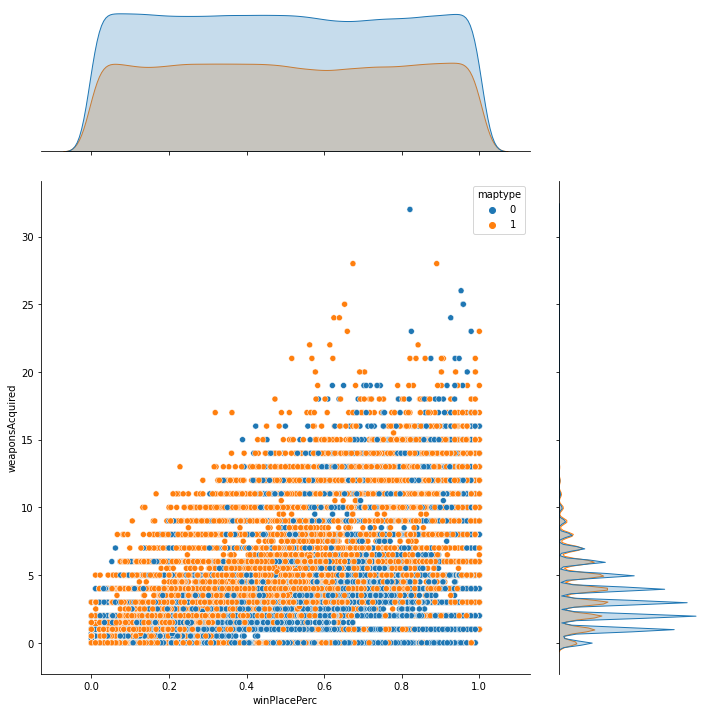

In [156]:
sns.jointplot(y='weaponsAcquired', x ='winPlacePerc', hue='maptype', data=solo_df, height=10, ratio=3)
plt.show()

- 획득하지 못한 경우 최하위권 예상
- 등수와 높은 상관관계를 확인


#### 아이템들간의 상관 관계 확인

- heals, boosts 관계 확인

In [157]:
plt.figure(figsize=(12, 8))
g0 = sns.scatterplot(x='winPlacePerc', y='heals', data=solo_df, alpha=0.8, label='heals')
g1 = sns.scatterplot(x='winPlacePerc', y='boosts', data=solo_df, alpha=0.3, label='boosts')
# g2 = sns.scatterplot(x='weaponsAcquired', y='boosts', data=solo_df, alpha=0.3, label='weaponsAcquired')


    - heals와 boost는 관계성이 있어 보임

- heals와 boosts를 합친 feature 생성 후 등수와의 관계 확인

In [158]:
solo_df['items'] = solo_df.heals + solo_df.boosts

In [159]:
solo_df[['boosts', 'heals', 'items', 'winPlacePerc']].corr()

boosts     heals     items  winPlacePerc
boosts        1.000000  0.505822  0.826772      0.643586
heals         0.505822  1.000000  0.903466      0.406691
items         0.826772  0.903466  1.000000      0.585019
winPlacePerc  0.643586  0.406691  0.585019      1.000000

- heals, boosts, weaponsAcquired 각각의 관계 확인

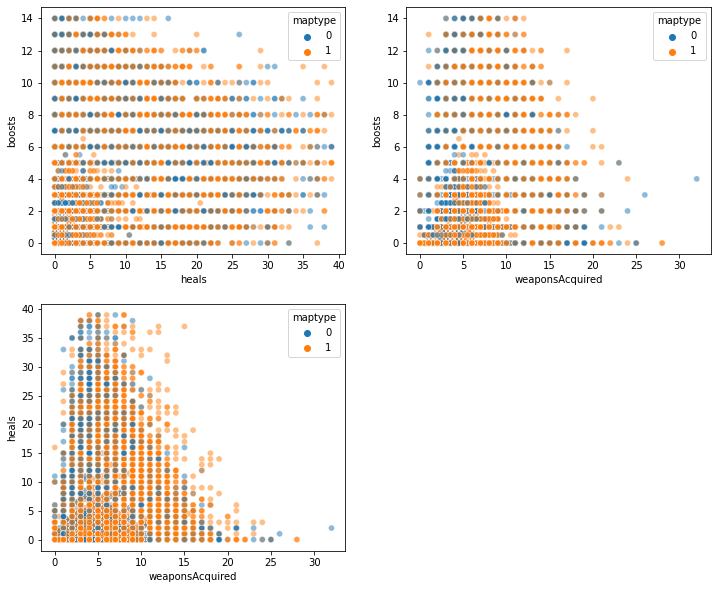

In [160]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
g2 = sns.scatterplot(x='heals', y='boosts', data=solo_df, alpha=0.5, hue='maptype')
plt.subplot(2, 2, 2)
g2 = sns.scatterplot(x='weaponsAcquired', y='boosts', data=solo_df, alpha=0.5, hue='maptype')
plt.subplot(2, 2, 3)
g2 = sns.scatterplot(x='weaponsAcquired', y='heals', data=solo_df, alpha=0.5, hue='maptype')
plt.show()


### Kill 관련 feature(kills, longestkill, killstreaks, headshotkills) 확인

In [161]:
solo_df[['kills', 'longestKill', 'killStreaks', 'headshotKills']].describe()


kills    longestKill    killStreaks  headshotKills
count  665715.000000  665715.000000  665715.000000  665715.000000
mean        0.947530      22.052020       0.486153       0.251829
std         1.506609      46.594652       0.555081       0.633584
min         0.000000       0.000000       0.000000       0.000000
25%         0.000000       0.000000       0.000000       0.000000
50%         0.000000       0.000000       0.000000       0.000000
75%         1.000000      21.990000       1.000000       0.000000
max        23.000000     921.900000       9.000000      14.000000

In [162]:
plt.figure(figsize=(12, 10))
plt.subplot(2, 2, 1)
g2 = sns.scatterplot(x='winPlacePerc', y='kills', data=solo_df, alpha=0.5)
plt.subplot(2, 2, 2)
g2 = sns.scatterplot(x='winPlacePerc', y='longestKill', data=solo_df, alpha=0.5)
plt.subplot(2, 2, 3)
g2 = sns.scatterplot(x='winPlacePerc', y='killStreaks', data=solo_df, alpha=0.5)
plt.subplot(2, 2, 4)
g2 = sns.scatterplot(x='winPlacePerc', y='headshotKills', data=solo_df, alpha=0.5)
plt.show()

In [163]:
solo_df[(solo_df['longestKill']==0)& (solo_df['kills']==0)].head(30)

assists  boosts  damageDealt  headshotKills  \
matchId        groupId                                                       
0002912fe5ed71 0acd4dd6620a6c      0.0     1.0         0.00            0.0   
               123e73e7f10a71      0.0     0.0         0.00            0.0   
               18d2006939f7fd      0.0     0.0        52.42            0.0   
               1d5625631e64d4      0.0     0.0         0.00            0.0   
               1e0afa45abc439      0.0     0.0         0.00            0.0   
               28556de2ef0575      0.0     0.0         0.00            0.0   
               330dba696b4214      0.0     0.0         0.00            0.0   
               34e5e1dce2df52      0.0     1.0         0.00            0.0   
               35de4787acc1cb      0.0     6.0       226.20            0.0   
               3657d2b94446c2      0.0     0.0         0.00            0.0   
               38b2725fe16840      0.0     3.0        21.78            0.0   
               4176a14e063881      0.0     2.0        77.24            0.0   
               43735a8827f063      0.0     0.0         0.00            0.0   
               4530f0d47f1736      0.0     0.0        40.78            0.0   
               45420f8aa2e4e9      0.0     0.0         0.00            0.0   
               47f731a76523d0      0.0     0.0         0.00            0.0   
               4b31269ead892c      0.0     0.0         0.00            0.0   
               4f7b977ad72bdd      0.0     0.0         0.00            0.0   
               507a615b1ea428      0.0     1.0         0.00            0.0   
               68076c3ea2f6eb      0.0     0.0         0.00            0.0   
               74a5c6ad42f065      0.0     1.0        28.38            0.0   
               7604543b06f72e      0.0     0.0         0.00            0.0   
               8038ec6e779bcc      0.0     0.0         0.00            0.0   
               805d30e791ebba      0.0     0.0        56.41            0.0   
               84d84021dbf624      0.0     0.0        40.64            0.0   
               8f59e08bf77ed2      0.0     0.0         0.00            0.0   
               95e2fb4c6edd8d      0.0     0.0        70.73            0.0   
               a175c81b93e93b      0.0     0.0        32.59            0.0   
               a1f0f3101c559b      0.0     0.0         0.00            0.0   
               a3162639af4f67      0.0     0.0         0.00            0.0   

                               heals  killPlace  kills  killStreaks  \
matchId        groupId                                                
0002912fe5ed71 0acd4dd6620a6c    4.0       59.0    0.0          0.0   
               123e73e7f10a71    0.0       60.0    0.0          0.0   
               18d2006939f7fd    0.0       81.0    0.0          0.0   
               1d5625631e64d4    0.0       74.0    0.0          0.0   
               1e0afa45abc439    0.0       72.0    0.0          0.0   
               28556de2ef0575    0.0       91.0    0.0          0.0   
               330dba696b4214    0.0       48.0    0.0          0.0   
               34e5e1dce2df52    0.0       51.0    0.0          0.0   
               35de4787acc1cb    2.0       45.0    0.0          0.0   
               3657d2b94446c2    0.0       90.0    0.0          0.0   
               38b2725fe16840    1.0       58.0    0.0          0.0   
               4176a14e063881    4.0       62.0    0.0          0.0   
               43735a8827f063    0.0       66.0    0.0          0.0   
               4530f0d47f1736    0.0       67.0    0.0          0.0   
               45420f8aa2e4e9    3.0       57.0    0.0          0.0   
               47f731a76523d0    0.0       94.0    0.0          0.0   
               4b31269ead892c    0.0       78.0    0.0          0.0   
               4f7b977ad72bdd    0.0       87.0    0.0          0.0   
               507a615b1ea428    0.0       53.0    0.0          0.0   
               68076c3ea2f6eb    0.0       

In [164]:
solo_df = solo_df.drop(columns=['killStreaks','headshotKills'])

In [165]:
solo_df = solo_df.drop(columns=['hack_user_team','hack_user_game', 'items'])

In [166]:
solo_df = solo_df.drop(columns=['assists'])

In [167]:
train_df = pd.concat([solo_df, team_df])

In [168]:
train_df = train_df.drop(columns='team_members')
solo_df = solo_df.drop(columns='team_members')

In [169]:
train_df.index.get_level_values(0).nunique()

45816

- 10000경기 샘플링

In [170]:
temp_df = train_df.reset_index()
solo_df = solo_df.reset_index()

In [171]:
temp_df = temp_df.groupby('matchId').agg(np.mean)

In [172]:
temp_df.maptype.value_counts()

0.0    26764
1.0    19052
Name: maptype, dtype: int64

In [173]:
temp_df.match_type_numerical.value_counts()

2.0    24822
1.0    13721
0.0     7273
Name: match_type_numerical, dtype: int64

In [174]:
team_df = team_df.reset_index()

- dataframe을 matchtype으로 나눈다

In [175]:
duo = team_df[team_df.match_type_numerical==1].copy()
squad = team_df[team_df.match_type_numerical==2].copy()

In [176]:
import random
def sample_match(df):
    sample =list(set(df.matchId))
    random.shuffle(sample)
    sample = sample[:int(len(sample)/5)]
    return str(sample)

In [177]:
temp = sample_match(solo_df)
sample_solo = solo_df[solo_df.matchId.apply(lambda x : True if temp.find(x) != -1 else False)]

In [178]:
temp = sample_match(duo)
sample_duo = duo[duo.matchId.apply(lambda x : True if temp.find(x) != -1 else False)]

In [179]:
temp = sample_match(squad)
sample_squad = squad[squad.matchId.apply(lambda x : True if temp.find(x) != -1 else False)]

In [180]:
sample_squad

matchId         groupId  boosts  damageDealt     heals  \
627235   0000a43bce5eec  18b16ec699d8b6    0.50   109.675000  0.500000   
627236   0000a43bce5eec  236ab9e9c081b9    0.00    47.988333  0.000000   
627237   0000a43bce5eec  3a6addfa0df938    0.00     0.000000  0.000000   
627238   0000a43bce5eec  4bf06994bd4c9a    0.50    11.700000  0.000000   
627239   0000a43bce5eec  4d1bbbc19b9084    3.50   340.950000  1.000000   
...                 ...             ...     ...          ...       ...   
1299303  fffa170cf8ed83  ce6f789bdb19e5    3.60   197.708000  3.200000   
1299304  fffa170cf8ed83  d5750604aada51    0.00   275.816667  0.666667   
1299305  fffa170cf8ed83  e086404a970ef8    1.75    90.675000  3.000000   
1299306  fffa170cf8ed83  e294ccd2aeaac6    0.00    11.610000  0.000000   
1299307  fffa170cf8ed83  f187b378e61a12    0.00   121.696667  0.666667   

         killPlace     kills  longestKill  maxPlace  rideDistance  \
627235   41.000000  1.000000     6.275000      28.0         0.000   
627236   90.500000  0.000000     0.000000      28.0         0.000   
627237   94.500000  0.000000     0.000000      28.0         0.000   
627238   59.500000  0.000000     0.000000      28.0         0.000   
627239   14.000000  3.000000    25.230000      28.0        79.953   
...            ...       ...          ...       ...           ...   
1299303  22.600000  1.800000    49.278000      30.0         0.000   
1299304  34.000000  1.666667     9.943333      30.0         0.000   
1299305  27.500000  1.000000    27.084000      30.0         0.000   
1299306  91.500000  0.000000     0.000000      30.0         0.000   
1299307  38.333333  1.333333     7.100667      30.0         0.000   

         walkDistance  weaponsAcquired  winPlacePerc  team_members  \
627235     131.685000         1.000000        0.3333           2.0   
627236      19.931833         0.833333        0.0370           6.0   
627237       4.818000         0.500000        0.0000           2.0   
627238     559.050000         7.000000        0.3704           2.0   
627239    3292.500000         4.000000        1.0000           2.0   
...               ...              ...           ...           ...   
1299303   2880.400000         5.400000        0.7931           5.0   
1299304    120.923333         2.666667        0.4138           3.0   
1299305   2100.575000         4.000000        0.9310           4.0   
1299306     22.190000         1.000000        0.0345           2.0   
1299307    114.423333         2.333333        0.2414           3.0   

         match_type_numerical  maptype  
627235                    2.0        0  
627236                    2.0        0  
627237                    2.0        0  
627238                    2.0        0  
627239                    2.0        0  
...                       ...      ...  
1299303                   2.0        0  
1299304                   2.0        0  
1299305                   2.0        0  
1299306                   2.0        0  
1299307                   2.0        0  

[134484 rows x 16 columns]

In [181]:
sample_train = pd.concat([sample_solo, sample_duo, sample_squad])

In [198]:
sample_train = sample_train.drop(columns=['team_members'])

In [199]:
x = sample_train.drop(columns=['winPlacePerc', 'matchId', 'groupId']).copy()
y = sample_train['winPlacePerc']

In [200]:
# sample_train.to_csv(data_path + 'sample_train.csv')

In [201]:
x.maptype = x.maptype.astype(float)

In [202]:
from sklearn.model_selection import train_test_split

In [203]:
X_train, X_test, y_train, y_test = train_test_split( x, y, test_size=0.2, random_state=42)

In [204]:
X_train

boosts  damageDealt  heals  killPlace  kills  longestKill  maxPlace  \
350704     0.00       44.880   0.00       81.0   0.00       0.0000      92.0   
136054     5.00      360.500   5.50        6.0   3.50      35.8350      47.0   
75147      3.50      646.450   2.50        6.5   4.50      26.0515      50.0   
591002     0.00       36.210   0.00       83.0   0.00       0.0000      93.0   
29692      0.00      100.000   0.00       30.0   1.00      11.5500      99.0   
...         ...          ...    ...        ...    ...          ...       ...   
630822     3.75      246.140   7.75       14.5   2.25      50.1900      29.0   
1161285    0.50      204.090   0.50       46.0   0.50      16.3100      27.0   
660088     3.00      218.400   6.00       26.0   1.00      37.3100      98.0   
70420      0.00       42.145   0.00       46.5   0.00       0.0000      49.0   
605256     0.00        0.000   0.00       57.0   0.00       0.0000      99.0   

         rideDistance  walkDistance  weaponsAcquired  match_type_numerical  \
350704          0.000         31.66             1.00                   0.0   
136054       1914.500       2586.00             6.50                   1.0   
75147           0.000       2408.00             5.50                   1.0   
591002          0.000         34.08             1.00                   0.0   
29692           0.000       1066.00             4.00                   0.0   
...               ...           ...              ...                   ...   
630822        470.575       2283.75             6.75                   2.0   
1161285         0.000        741.45             3.50                   2.0   
660088          0.000       1812.00             5.00                   0.0   
70420           0.000        949.35             6.50                   1.0   
605256          0.000        439.90             4.00                   0.0   

         maptype  
350704       1.0  
136054       1.0  
75147        0.0  
591002       0.0  
29692        0.0  
...          ...  
630822       0.0  
1161285      0.0  
660088       0.0  
70420        0.0  
605256       0.0  

[314284 rows x 12 columns]

이번에는 XGBoost 를 이용하여 동일한 데이터를 구분하는 판별기를 학습해 봅니다. XGBoost 의 버전은 0.90 또는 1.6.1 입니다.

In [188]:
!pip install xgboost

In [205]:
import warnings
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

print(f'xgboost=={xgb.__version__}')

xgboost==1.6.1


XGBoost 역시 scikit-learn 처럼 손쉽게 학습을 할 수 있습니다. 우선 boosting trees 의 개수를 10 개로 적게 설정해봅니다. 정확도가 같습니다.

In [206]:
xgb_clf = xgb.XGBRegressor(
    n_estimators = 100,
    max_depth = 10,
    booster = 'gbtree',
    eta = 0.3,
    gamma = 0,    
    nthread = 4,
    base_score = 0.5,
)

xgb_clf.fit(X_train, y_train)
y_pred_xgb = xgb_clf.predict(X_test)
xgb_clf.score(X_test, y_test)

0.9395381806811587

In [207]:
xgb_clf.score(X_test, y_test)

0.9395381806811587

In [208]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(y_test, y_pred_xgb)

0.005342534165049348

In [213]:
mean_absolute_error(y_test, y_pred_xgb)

0.07677129796193959

In [209]:
from sklearn.model_selection import cross_val_score

## DecisionTreeRegressor

In [210]:
from sklearn.tree import DecisionTreeRegressor

dt_model = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
df_score = dt_model.score(X_test, y_test) * 100
np.round(df_score, 2)

87.1

- k-fold cross validation score

In [211]:
scores = cross_val_score(dt_model, X_test, y_test, cv=10)
scores.mean(), scores.var()

(0.8624797520932397, 1.6223356091077144e-05)

- MAE

In [212]:
y_pred_xgb = dt_model.predict(X_test)
mean_absolute_error(y_test, y_pred_xgb)

0.07677129796193959

## RandomForestRegressor

- RandomForestRegressor(
    - n_estimators=100, *, criterion="squared_error", 

        max_depth=None, min_samples_split=2, 
    
        min_samples_leaf=1, min_weight_fraction_leaf=0, 
    
        max_features="auto", max_leaf_nodes=None, 
    
        min_impurity_decrease=0, bootstrap=True, 
    
        oob_score=False, n_jobs=None, 
    
        random_state=None, verbose=0, 
        
        warm_start=False, ccp_alpha=0, 
        
        max_samples=None   )

In [215]:
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(random_state=0).fit(X_train, y_train)
rf_score = rf_model.score(X_test, y_test) * 100
np.round(rf_score, 2)

93.62

- k-fold cross validation score
    - 분산이 크면 데이터에 따라서 모델의 정확도 차이가 크므로 과적합의 위험이 크다.

In [216]:
scores = cross_val_score(rf_model, X_test, y_test, cv=10)
scores.mean(), scores.var()

(0.931265294433097, 4.01541698032258e-06)

- MAE

In [217]:
y_pred_rf = rf_model.predict(X_test)
mean_absolute_error(y_test, y_pred_rf)

0.05493061295089613

- max_features : sqrt

In [218]:
rf = RandomForestRegressor(n_estimators=100, random_state=0, max_features='sqrt')
rf.fit(X_train, y_train)
print('tarin score : ', rf.score(X_train, y_train), '\t','test score :', rf.score(X_test, y_test))
print('MAE :')

tarin score :  0.9911436053519446 	 test score : 0.9363639096944658
MAE :


- leaf node size(마지막 노드 갯수) : 100

In [ ]:
rf = RandomForestRegressor(n_estimators=100, random_state=0, max_features='sqrt', max_leaf_nodes=100)
rf.fit(X_train, y_train)
print(rf)

In [ ]:
# tree size
rf = RandomForestRegressor(n_estimators=100, random_state=0,
                           max_features='sqrt', max_leaf_nodes=100)
rf.fit(xtrain,ytrain)
print(rf.score(xtrain, ytrain), rf.score(xtest, ytest))

In [ ]:
# oob score
rf = RandomForestRegressor(n_estimators=100,random_state=0,
                           max_features='sqrt',max_leaf_nodes=100,
                           oob_score=True)
rf.fit(xtrain,ytrain)
print(rf.score(xtrain,ytrain), rf.score(xtest,ytest))
print(rf.oob_score_)  # out-of-bag score 낮을수록 좋다.

In [ ]:
# parameter tuning using oob scores
tree_size = np.arange(2, 50, 2)
s = np.zeros((len(tree_size),4))

for i in range(len(tree_size)):
    rf = RandomForestRegressor(n_estimators=100, random_state=0,
                           max_features='sqrt', max_leaf_nodes=tree_size[i],
                           oob_score=True)
    rf.fit(xtrain,ytrain)
    s[i,0] = rf.score(xtrain,ytrain)
    s[i,1] = rf.oob_score_ 
    s[i,2] = cross_val_score(rf,xtrain,ytrain,cv=5).mean()
    s[i,3] = rf.score(xtest,ytest)

plt.plot(tree_size, s)

## BaggingRegressor, KNeighborsRegressor

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(xtrain, ytrain)
print(knn.score(xtrain, ytrain), knn.score(xtest, ytest))

In [ ]:
# full bagging
bf = BaggingRegressor(knn, n_estimators=100, max_samples=1.0, max_features=1.0, random_state=0)
bf.fit(xtrain, ytrain)
print(bf.score(xtrain, ytrain), bf.score(xtest, ytest))

In [ ]:
# bagging with subsampling and feature randomization
bf = BaggingRegressor(knn, n_estimators=500, max_samples=0.5, max_features=0.5)
bf.fit(xtrain, ytrain)
print(bf.score(xtrain, ytrain), bf.score(xtest, ytest))

In [ ]:
# effect of estimators
np.random.seed(0)
n_list = [1,5,10,20,30,50,100,200,500,1000]
s = np.zeros((len(n_list),2))
for i in range(len(n_list)):
    bf = BaggingRegressor(knn, n_estimators=n_list[i], max_samples=0.5, max_features=0.5)
    bf.fit(xtrain, ytrain)
    s[i,0] = bf.score(xtrain,ytrain)
    s[i,1] = bf.score(xtest,ytest)
plt.plot(np.log10(n_list),s,marker='o')

In [ ]:
# parameter tunning
np.random.seed(1)
params = np.arange(2,20,2)
s = np.zeros((len(params),3))
for i in range(len(params)):
    f = BaggingRegressor(KNeighborsRegressor(params[i]), n_estimators=200,
                          random_state=0, max_samples=0.5, max_features=0.5, oob_score=True)
    f.fit(xtrain, ytrain)
    s[i,0] = f.score(xtrain, ytrain)
    s[i,1] = cross_val_score(f,xtrain, ytrain, cv=5).mean()
    s[i,2] = f.score(xtest, ytest)